In [428]:
import pandas as pd
import numpy as np
import random
import argparse
import math as math
import matplotlib.pyplot as plt
import statistics as st
from modules import Annotation_project_functions as func
from modules import Datasets as mydatasets 
from modules import NN_models as mynn 
import statistics
#word2vec
import gensim.models.keyedvectors as word2vec
from gensim.models.keyedvectors import KeyedVectors as wk

#Biopython
from Bio.Align import MultipleSeqAlignment
from Bio import SeqIO
from Bio.pairwise2 import format_alignment
from Bio import pairwise2
from Bio import Entrez
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation


#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential
from torch.utils.data import BatchSampler, SequentialSampler 
from torch.optim import Adam
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# tensorboard
from torch.utils.tensorboard import SummaryWriter

#figure package
from dna_features_viewer import GraphicFeature, GraphicRecord

### I) Prepare data

In [225]:
ground_truth_file ='/Users/lou/Documents/Travail/Projet de master/Data/Ground_truth_df.csv'
ground_truth = pd.read_csv(ground_truth_file)


In [226]:
embedding_file = '/Users/lou/Documents/Travail/Projet de master/Scripts/Part6_scoring/data/dna2vec-20200713-1659-k7to7-100d-10c-155Mbp-sliding-lee.w2v'
w2v = wk.load_word2vec_format(embedding_file, binary = False)

In [227]:
path_to_kmers= '/Users/lou/Documents/Travail/Projet de master/Scripts/Part6_scoring/data/StartCodons_ReadSim_exactPos_7mers_20200713-22-29-38_shuffled'
kmers = pd.read_csv(path_to_kmers)
kmers.drop(['Unnamed: 0','Unnamed: 0.1'],axis = 1, inplace = True)

path_to_reads= '/Users/lou/Documents/Travail/Projet de master/Scripts/Part6_scoring/data/ReadSim_nb-300_noise-10_date-20200713-18-48-44'
reads = pd.read_csv(path_to_reads)
reads.drop(['Unnamed: 0'],axis = 1, inplace = True)

kmers_df = kmers.merge(reads[['Noisy_read','Noisy_read_len']], left_on= kmers.Read_id, right_on = reads.index, suffixes = ('_run','')).drop(['key_0'], axis =1)
kmers_df.sample(2)


,Read_id,Embedding,Kmers,Pos_kmer_in_read,Pos_codon_in_read,Strain,Strand,Read_start,Read_end,Indel_pos,Indel_size,Kmer_pos_in_genome,Codon_pos_in_genome,Real_pos_codon_in_read,Real_pos_codon_in_genome,Is_start_codon,Locus_tag,Noisy_read,Noisy_read_len
1845,2028,[ 0.2490015 0.30549353 -0.24348573 0.255904...,GCCATGT,4814,4817,NC_011751.1,1,2154744,2167574,"[10909, 7058, 7870, 9938, 12606, 7928, 8475, 1...","[-3, 4, 1, 1, -1, -1, -1, 3, -5, -2, -2, 3, 1,...",2159558,2159561,4805,2159549,1,ECUMN_2139,TTCTGGTTGTTCCCGGTGGCGATTGAAGCCCTGATCGATAAAGTGA...,12871
17812,701,[ 1.04055844e-01 5.31929374e-01 -1.34514585e-...,TCGTGGC,3344,3346,NC_018658.1,1,3859331,3876076,"[11136, 4320, 423, 11430, 16492, 7738, 2939, 1...","[-4, -1, 1, -2, 2, -3, -2, 3, -1, 1, -4, -1, 2...",3862675,3862677,3305,3862636,1,O3K_18880,GCGCATCGAATATCGTCGGTCGCCCATGAGCATGGAACTGTTGCTC...,16716


In [228]:
# convert string array to list
kmers_df.Indel_pos = kmers_df.Indel_pos.str.strip('[ ]')
kmers_df.Indel_pos = kmers_df.Indel_pos.str.split(',')
kmers_df.Indel_size = kmers_df.Indel_size.str.strip('[]')
kmers_df.Indel_size = kmers_df.Indel_size.str.split(',')



In [229]:
# convert insert and del lists to numeric if possible
no_indel_count = 0
no_subs_count = 0
for idx in kmers_df.index:
    print('Step:',idx,'/',kmers_df.index[-1])
    try:
        kmers_df.Indel_pos.loc[idx] = [int(i) for i in kmers_df.Indel_pos.loc[idx]]
    except (ValueError,TypeError):
        print('No insertion or deletion for this read:', idx)
        no_indel_count += 1
        kmers_df.Indel_pos.loc[idx] =np.nan
    try:
        kmers_df.Indel_size.loc[idx] = [int(i) for i in kmers_df.Indel_size.loc[idx]]
    except (ValueError,TypeError):
        kmers_df.Indel_size.loc[idx] =np.nan

   

Step: 0 / 20199
Step: 1 / 20199
Step: 2 / 20199
Step: 3 / 20199
Step: 4 / 20199
Step: 5 / 20199
Step: 6 / 20199
Step: 7 / 20199
Step: 8 / 20199
Step: 9 / 20199
Step: 10 / 20199
Step: 11 / 20199
Step: 12 / 20199
Step: 13 / 20199
Step: 14 / 20199
Step: 15 / 20199
Step: 16 / 20199
Step: 17 / 20199
Step: 18 / 20199
Step: 19 / 20199
Step: 20 / 20199
Step: 21 / 20199
Step: 22 / 20199
Step: 23 / 20199
Step: 24 / 20199
Step: 25 / 20199
Step: 26 / 20199
Step: 27 / 20199
Step: 28 / 20199
Step: 29 / 20199
Step: 30 / 20199
Step: 31 / 20199
Step: 32 / 20199
Step: 33 / 20199
Step: 34 / 20199
Step: 35 / 20199
Step: 36 / 20199
Step: 37 / 20199
Step: 38 / 20199
Step: 39 / 20199
Step: 40 / 20199
Step: 41 / 20199
Step: 42 / 20199
Step: 43 / 20199
Step: 44 / 20199
Step: 45 / 20199
Step: 46 / 20199
Step: 47 / 20199
Step: 48 / 20199
Step: 49 / 20199
Step: 50 / 20199
Step: 51 / 20199
Step: 52 / 20199
Step: 53 / 20199
Step: 54 / 20199
Step: 55 / 20199
Step: 56 / 20199
Step: 57 / 20199
Step: 58 / 20199
Step: 5

/Users/lou/anaconda3/envs/tudelft/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


 133 / 20199
Step: 134 / 20199
Step: 135 / 20199
Step: 136 / 20199
Step: 137 / 20199
Step: 138 / 20199
Step: 139 / 20199
Step: 140 / 20199
Step: 141 / 20199
Step: 142 / 20199
Step: 143 / 20199
Step: 144 / 20199
Step: 145 / 20199
Step: 146 / 20199
Step: 147 / 20199
Step: 148 / 20199
Step: 149 / 20199
Step: 150 / 20199
Step: 151 / 20199
Step: 152 / 20199
Step: 153 / 20199
Step: 154 / 20199
Step: 155 / 20199
Step: 156 / 20199
Step: 157 / 20199
Step: 158 / 20199
Step: 159 / 20199
Step: 160 / 20199
Step: 161 / 20199
Step: 162 / 20199
Step: 163 / 20199
Step: 164 / 20199
Step: 165 / 20199
Step: 166 / 20199
Step: 167 / 20199
Step: 168 / 20199
Step: 169 / 20199
Step: 170 / 20199
Step: 171 / 20199
Step: 172 / 20199
Step: 173 / 20199
Step: 174 / 20199
Step: 175 / 20199
Step: 176 / 20199
Step: 177 / 20199
Step: 178 / 20199
Step: 179 / 20199
Step: 180 / 20199
Step: 181 / 20199
Step: 182 / 20199
Step: 183 / 20199
Step: 184 / 20199
Step: 185 / 20199
Step: 186 / 20199
Step: 187 / 20199
Step: 188 / 201

Step: 603 / 20199
Step: 604 / 20199
Step: 605 / 20199
Step: 606 / 20199
Step: 607 / 20199
Step: 608 / 20199
Step: 609 / 20199
Step: 610 / 20199
Step: 611 / 20199
Step: 612 / 20199
Step: 613 / 20199
Step: 614 / 20199
Step: 615 / 20199
Step: 616 / 20199
Step: 617 / 20199
Step: 618 / 20199
Step: 619 / 20199
Step: 620 / 20199
Step: 621 / 20199
Step: 622 / 20199
Step: 623 / 20199
Step: 624 / 20199
Step: 625 / 20199
Step: 626 / 20199
Step: 627 / 20199
Step: 628 / 20199
Step: 629 / 20199
Step: 630 / 20199
Step: 631 / 20199
Step: 632 / 20199
Step: 633 / 20199
Step: 634 / 20199
Step: 635 / 20199
Step: 636 / 20199
Step: 637 / 20199
Step: 638 / 20199
Step: 639 / 20199
Step: 640 / 20199
Step: 641 / 20199
Step: 642 / 20199
Step: 643 / 20199
Step: 644 / 20199
Step: 645 / 20199
Step: 646 / 20199
Step: 647 / 20199
Step: 648 / 20199
Step: 649 / 20199
Step: 650 / 20199
Step: 651 / 20199
Step: 652 / 20199
Step: 653 / 20199
Step: 654 / 20199
Step: 655 / 20199
Step: 656 / 20199
Step: 657 / 20199
Step: 658 

Step: 1192 / 20199
Step: 1193 / 20199
Step: 1194 / 20199
Step: 1195 / 20199
Step: 1196 / 20199
Step: 1197 / 20199
Step: 1198 / 20199
Step: 1199 / 20199
Step: 1200 / 20199
Step: 1201 / 20199
Step: 1202 / 20199
Step: 1203 / 20199
Step: 1204 / 20199
Step: 1205 / 20199
Step: 1206 / 20199
Step: 1207 / 20199
Step: 1208 / 20199
Step: 1209 / 20199
Step: 1210 / 20199
Step: 1211 / 20199
Step: 1212 / 20199
Step: 1213 / 20199
Step: 1214 / 20199
Step: 1215 / 20199
Step: 1216 / 20199
Step: 1217 / 20199
Step: 1218 / 20199
Step: 1219 / 20199
Step: 1220 / 20199
Step: 1221 / 20199
Step: 1222 / 20199
Step: 1223 / 20199
Step: 1224 / 20199
Step: 1225 / 20199
Step: 1226 / 20199
Step: 1227 / 20199
Step: 1228 / 20199
Step: 1229 / 20199
Step: 1230 / 20199
Step: 1231 / 20199
Step: 1232 / 20199
Step: 1233 / 20199
Step: 1234 / 20199
Step: 1235 / 20199
Step: 1236 / 20199
Step: 1237 / 20199
Step: 1238 / 20199
Step: 1239 / 20199
Step: 1240 / 20199
Step: 1241 / 20199
Step: 1242 / 20199
Step: 1243 / 20199
Step: 1244 /

Step: 1735 / 20199
Step: 1736 / 20199
Step: 1737 / 20199
Step: 1738 / 20199
Step: 1739 / 20199
Step: 1740 / 20199
Step: 1741 / 20199
Step: 1742 / 20199
Step: 1743 / 20199
Step: 1744 / 20199
Step: 1745 / 20199
Step: 1746 / 20199
Step: 1747 / 20199
Step: 1748 / 20199
Step: 1749 / 20199
Step: 1750 / 20199
Step: 1751 / 20199
Step: 1752 / 20199
Step: 1753 / 20199
Step: 1754 / 20199
Step: 1755 / 20199
Step: 1756 / 20199
Step: 1757 / 20199
Step: 1758 / 20199
Step: 1759 / 20199
Step: 1760 / 20199
Step: 1761 / 20199
Step: 1762 / 20199
Step: 1763 / 20199
Step: 1764 / 20199
Step: 1765 / 20199
Step: 1766 / 20199
Step: 1767 / 20199
Step: 1768 / 20199
Step: 1769 / 20199
Step: 1770 / 20199
Step: 1771 / 20199
Step: 1772 / 20199
Step: 1773 / 20199
Step: 1774 / 20199
Step: 1775 / 20199
Step: 1776 / 20199
Step: 1777 / 20199
Step: 1778 / 20199
Step: 1779 / 20199
Step: 1780 / 20199
Step: 1781 / 20199
Step: 1782 / 20199
Step: 1783 / 20199
Step: 1784 / 20199
Step: 1785 / 20199
Step: 1786 / 20199
Step: 1787 /

Step: 2286 / 20199
Step: 2287 / 20199
Step: 2288 / 20199
Step: 2289 / 20199
Step: 2290 / 20199
Step: 2291 / 20199
Step: 2292 / 20199
Step: 2293 / 20199
Step: 2294 / 20199
Step: 2295 / 20199
Step: 2296 / 20199
Step: 2297 / 20199
Step: 2298 / 20199
Step: 2299 / 20199
Step: 2300 / 20199
Step: 2301 / 20199
Step: 2302 / 20199
Step: 2303 / 20199
Step: 2304 / 20199
Step: 2305 / 20199
Step: 2306 / 20199
Step: 2307 / 20199
Step: 2308 / 20199
Step: 2309 / 20199
Step: 2310 / 20199
Step: 2311 / 20199
Step: 2312 / 20199
Step: 2313 / 20199
Step: 2314 / 20199
Step: 2315 / 20199
Step: 2316 / 20199
Step: 2317 / 20199
Step: 2318 / 20199
Step: 2319 / 20199
Step: 2320 / 20199
Step: 2321 / 20199
Step: 2322 / 20199
Step: 2323 / 20199
Step: 2324 / 20199
Step: 2325 / 20199
Step: 2326 / 20199
Step: 2327 / 20199
Step: 2328 / 20199
Step: 2329 / 20199
Step: 2330 / 20199
Step: 2331 / 20199
Step: 2332 / 20199
Step: 2333 / 20199
Step: 2334 / 20199
Step: 2335 / 20199
Step: 2336 / 20199
Step: 2337 / 20199
Step: 2338 /

Step: 2834 / 20199
Step: 2835 / 20199
Step: 2836 / 20199
Step: 2837 / 20199
Step: 2838 / 20199
Step: 2839 / 20199
Step: 2840 / 20199
Step: 2841 / 20199
Step: 2842 / 20199
Step: 2843 / 20199
Step: 2844 / 20199
Step: 2845 / 20199
Step: 2846 / 20199
Step: 2847 / 20199
Step: 2848 / 20199
Step: 2849 / 20199
Step: 2850 / 20199
Step: 2851 / 20199
Step: 2852 / 20199
Step: 2853 / 20199
Step: 2854 / 20199
Step: 2855 / 20199
Step: 2856 / 20199
Step: 2857 / 20199
Step: 2858 / 20199
Step: 2859 / 20199
Step: 2860 / 20199
Step: 2861 / 20199
Step: 2862 / 20199
Step: 2863 / 20199
Step: 2864 / 20199
Step: 2865 / 20199
Step: 2866 / 20199
Step: 2867 / 20199
Step: 2868 / 20199
Step: 2869 / 20199
Step: 2870 / 20199
Step: 2871 / 20199
Step: 2872 / 20199
Step: 2873 / 20199
Step: 2874 / 20199
Step: 2875 / 20199
Step: 2876 / 20199
Step: 2877 / 20199
Step: 2878 / 20199
Step: 2879 / 20199
Step: 2880 / 20199
Step: 2881 / 20199
Step: 2882 / 20199
Step: 2883 / 20199
Step: 2884 / 20199
Step: 2885 / 20199
Step: 2886 /

Step: 3387 / 20199
Step: 3388 / 20199
Step: 3389 / 20199
Step: 3390 / 20199
Step: 3391 / 20199
Step: 3392 / 20199
Step: 3393 / 20199
Step: 3394 / 20199
Step: 3395 / 20199
Step: 3396 / 20199
Step: 3397 / 20199
Step: 3398 / 20199
Step: 3399 / 20199
Step: 3400 / 20199
Step: 3401 / 20199
Step: 3402 / 20199
Step: 3403 / 20199
Step: 3404 / 20199
Step: 3405 / 20199
Step: 3406 / 20199
Step: 3407 / 20199
Step: 3408 / 20199
Step: 3409 / 20199
Step: 3410 / 20199
Step: 3411 / 20199
Step: 3412 / 20199
Step: 3413 / 20199
Step: 3414 / 20199
Step: 3415 / 20199
Step: 3416 / 20199
Step: 3417 / 20199
Step: 3418 / 20199
Step: 3419 / 20199
Step: 3420 / 20199
Step: 3421 / 20199
Step: 3422 / 20199
Step: 3423 / 20199
Step: 3424 / 20199
Step: 3425 / 20199
Step: 3426 / 20199
Step: 3427 / 20199
Step: 3428 / 20199
Step: 3429 / 20199
Step: 3430 / 20199
Step: 3431 / 20199
Step: 3432 / 20199
Step: 3433 / 20199
Step: 3434 / 20199
Step: 3435 / 20199
Step: 3436 / 20199
Step: 3437 / 20199
Step: 3438 / 20199
Step: 3439 /

Step: 3976 / 20199
Step: 3977 / 20199
Step: 3978 / 20199
Step: 3979 / 20199
Step: 3980 / 20199
Step: 3981 / 20199
Step: 3982 / 20199
Step: 3983 / 20199
Step: 3984 / 20199
Step: 3985 / 20199
Step: 3986 / 20199
Step: 3987 / 20199
Step: 3988 / 20199
Step: 3989 / 20199
Step: 3990 / 20199
Step: 3991 / 20199
Step: 3992 / 20199
Step: 3993 / 20199
Step: 3994 / 20199
Step: 3995 / 20199
Step: 3996 / 20199
Step: 3997 / 20199
Step: 3998 / 20199
Step: 3999 / 20199
Step: 4000 / 20199
Step: 4001 / 20199
Step: 4002 / 20199
Step: 4003 / 20199
Step: 4004 / 20199
Step: 4005 / 20199
Step: 4006 / 20199
Step: 4007 / 20199
Step: 4008 / 20199
Step: 4009 / 20199
Step: 4010 / 20199
Step: 4011 / 20199
Step: 4012 / 20199
Step: 4013 / 20199
Step: 4014 / 20199
Step: 4015 / 20199
Step: 4016 / 20199
Step: 4017 / 20199
Step: 4018 / 20199
Step: 4019 / 20199
Step: 4020 / 20199
Step: 4021 / 20199
Step: 4022 / 20199
Step: 4023 / 20199
Step: 4024 / 20199
Step: 4025 / 20199
Step: 4026 / 20199
Step: 4027 / 20199
Step: 4028 /

Step: 4546 / 20199
Step: 4547 / 20199
Step: 4548 / 20199
Step: 4549 / 20199
Step: 4550 / 20199
Step: 4551 / 20199
Step: 4552 / 20199
Step: 4553 / 20199
Step: 4554 / 20199
Step: 4555 / 20199
Step: 4556 / 20199
Step: 4557 / 20199
Step: 4558 / 20199
Step: 4559 / 20199
Step: 4560 / 20199
Step: 4561 / 20199
Step: 4562 / 20199
Step: 4563 / 20199
Step: 4564 / 20199
Step: 4565 / 20199
Step: 4566 / 20199
Step: 4567 / 20199
Step: 4568 / 20199
Step: 4569 / 20199
Step: 4570 / 20199
Step: 4571 / 20199
Step: 4572 / 20199
Step: 4573 / 20199
Step: 4574 / 20199
Step: 4575 / 20199
Step: 4576 / 20199
Step: 4577 / 20199
Step: 4578 / 20199
Step: 4579 / 20199
Step: 4580 / 20199
Step: 4581 / 20199
Step: 4582 / 20199
Step: 4583 / 20199
Step: 4584 / 20199
Step: 4585 / 20199
Step: 4586 / 20199
Step: 4587 / 20199
Step: 4588 / 20199
Step: 4589 / 20199
Step: 4590 / 20199
Step: 4591 / 20199
Step: 4592 / 20199
Step: 4593 / 20199
Step: 4594 / 20199
Step: 4595 / 20199
Step: 4596 / 20199
Step: 4597 / 20199
Step: 4598 /

Step: 5067 / 20199
Step: 5068 / 20199
Step: 5069 / 20199
Step: 5070 / 20199
Step: 5071 / 20199
Step: 5072 / 20199
Step: 5073 / 20199
Step: 5074 / 20199
Step: 5075 / 20199
Step: 5076 / 20199
Step: 5077 / 20199
Step: 5078 / 20199
Step: 5079 / 20199
Step: 5080 / 20199
Step: 5081 / 20199
Step: 5082 / 20199
Step: 5083 / 20199
Step: 5084 / 20199
Step: 5085 / 20199
Step: 5086 / 20199
Step: 5087 / 20199
Step: 5088 / 20199
Step: 5089 / 20199
Step: 5090 / 20199
Step: 5091 / 20199
Step: 5092 / 20199
Step: 5093 / 20199
Step: 5094 / 20199
Step: 5095 / 20199
Step: 5096 / 20199
Step: 5097 / 20199
Step: 5098 / 20199
Step: 5099 / 20199
Step: 5100 / 20199
Step: 5101 / 20199
Step: 5102 / 20199
Step: 5103 / 20199
Step: 5104 / 20199
Step: 5105 / 20199
Step: 5106 / 20199
Step: 5107 / 20199
Step: 5108 / 20199
Step: 5109 / 20199
Step: 5110 / 20199
Step: 5111 / 20199
Step: 5112 / 20199
Step: 5113 / 20199
Step: 5114 / 20199
Step: 5115 / 20199
Step: 5116 / 20199
Step: 5117 / 20199
Step: 5118 / 20199
Step: 5119 /

Step: 5679 / 20199
Step: 5680 / 20199
Step: 5681 / 20199
Step: 5682 / 20199
Step: 5683 / 20199
Step: 5684 / 20199
Step: 5685 / 20199
Step: 5686 / 20199
Step: 5687 / 20199
Step: 5688 / 20199
Step: 5689 / 20199
Step: 5690 / 20199
Step: 5691 / 20199
Step: 5692 / 20199
Step: 5693 / 20199
Step: 5694 / 20199
Step: 5695 / 20199
Step: 5696 / 20199
Step: 5697 / 20199
Step: 5698 / 20199
Step: 5699 / 20199
Step: 5700 / 20199
Step: 5701 / 20199
Step: 5702 / 20199
Step: 5703 / 20199
Step: 5704 / 20199
Step: 5705 / 20199
Step: 5706 / 20199
Step: 5707 / 20199
Step: 5708 / 20199
Step: 5709 / 20199
Step: 5710 / 20199
Step: 5711 / 20199
Step: 5712 / 20199
Step: 5713 / 20199
Step: 5714 / 20199
Step: 5715 / 20199
Step: 5716 / 20199
Step: 5717 / 20199
Step: 5718 / 20199
Step: 5719 / 20199
Step: 5720 / 20199
Step: 5721 / 20199
Step: 5722 / 20199
Step: 5723 / 20199
Step: 5724 / 20199
Step: 5725 / 20199
Step: 5726 / 20199
Step: 5727 / 20199
Step: 5728 / 20199
Step: 5729 / 20199
Step: 5730 / 20199
Step: 5731 /

Step: 6184 / 20199
Step: 6185 / 20199
Step: 6186 / 20199
Step: 6187 / 20199
Step: 6188 / 20199
Step: 6189 / 20199
Step: 6190 / 20199
Step: 6191 / 20199
Step: 6192 / 20199
Step: 6193 / 20199
Step: 6194 / 20199
Step: 6195 / 20199
Step: 6196 / 20199
Step: 6197 / 20199
Step: 6198 / 20199
Step: 6199 / 20199
Step: 6200 / 20199
Step: 6201 / 20199
Step: 6202 / 20199
Step: 6203 / 20199
Step: 6204 / 20199
Step: 6205 / 20199
Step: 6206 / 20199
Step: 6207 / 20199
Step: 6208 / 20199
Step: 6209 / 20199
Step: 6210 / 20199
Step: 6211 / 20199
Step: 6212 / 20199
Step: 6213 / 20199
Step: 6214 / 20199
Step: 6215 / 20199
Step: 6216 / 20199
Step: 6217 / 20199
Step: 6218 / 20199
Step: 6219 / 20199
Step: 6220 / 20199
Step: 6221 / 20199
Step: 6222 / 20199
Step: 6223 / 20199
Step: 6224 / 20199
Step: 6225 / 20199
Step: 6226 / 20199
Step: 6227 / 20199
Step: 6228 / 20199
Step: 6229 / 20199
Step: 6230 / 20199
Step: 6231 / 20199
Step: 6232 / 20199
Step: 6233 / 20199
Step: 6234 / 20199
Step: 6235 / 20199
Step: 6236 /

Step: 6715 / 20199
Step: 6716 / 20199
Step: 6717 / 20199
Step: 6718 / 20199
Step: 6719 / 20199
Step: 6720 / 20199
Step: 6721 / 20199
Step: 6722 / 20199
Step: 6723 / 20199
Step: 6724 / 20199
Step: 6725 / 20199
Step: 6726 / 20199
Step: 6727 / 20199
Step: 6728 / 20199
Step: 6729 / 20199
Step: 6730 / 20199
Step: 6731 / 20199
Step: 6732 / 20199
Step: 6733 / 20199
Step: 6734 / 20199
Step: 6735 / 20199
Step: 6736 / 20199
Step: 6737 / 20199
Step: 6738 / 20199
Step: 6739 / 20199
Step: 6740 / 20199
Step: 6741 / 20199
Step: 6742 / 20199
Step: 6743 / 20199
Step: 6744 / 20199
Step: 6745 / 20199
Step: 6746 / 20199
Step: 6747 / 20199
Step: 6748 / 20199
Step: 6749 / 20199
Step: 6750 / 20199
Step: 6751 / 20199
Step: 6752 / 20199
Step: 6753 / 20199
Step: 6754 / 20199
Step: 6755 / 20199
Step: 6756 / 20199
Step: 6757 / 20199
Step: 6758 / 20199
Step: 6759 / 20199
Step: 6760 / 20199
Step: 6761 / 20199
Step: 6762 / 20199
Step: 6763 / 20199
Step: 6764 / 20199
Step: 6765 / 20199
Step: 6766 / 20199
Step: 6767 /

Step: 7277 / 20199
Step: 7278 / 20199
Step: 7279 / 20199
Step: 7280 / 20199
Step: 7281 / 20199
Step: 7282 / 20199
Step: 7283 / 20199
Step: 7284 / 20199
Step: 7285 / 20199
Step: 7286 / 20199
Step: 7287 / 20199
Step: 7288 / 20199
Step: 7289 / 20199
Step: 7290 / 20199
Step: 7291 / 20199
Step: 7292 / 20199
Step: 7293 / 20199
Step: 7294 / 20199
Step: 7295 / 20199
Step: 7296 / 20199
Step: 7297 / 20199
Step: 7298 / 20199
Step: 7299 / 20199
Step: 7300 / 20199
Step: 7301 / 20199
Step: 7302 / 20199
Step: 7303 / 20199
Step: 7304 / 20199
Step: 7305 / 20199
Step: 7306 / 20199
Step: 7307 / 20199
Step: 7308 / 20199
Step: 7309 / 20199
Step: 7310 / 20199
Step: 7311 / 20199
Step: 7312 / 20199
Step: 7313 / 20199
Step: 7314 / 20199
Step: 7315 / 20199
Step: 7316 / 20199
Step: 7317 / 20199
Step: 7318 / 20199
Step: 7319 / 20199
Step: 7320 / 20199
Step: 7321 / 20199
Step: 7322 / 20199
Step: 7323 / 20199
Step: 7324 / 20199
Step: 7325 / 20199
Step: 7326 / 20199
Step: 7327 / 20199
Step: 7328 / 20199
Step: 7329 /

Step: 7843 / 20199
Step: 7844 / 20199
Step: 7845 / 20199
Step: 7846 / 20199
Step: 7847 / 20199
Step: 7848 / 20199
Step: 7849 / 20199
Step: 7850 / 20199
Step: 7851 / 20199
Step: 7852 / 20199
Step: 7853 / 20199
Step: 7854 / 20199
Step: 7855 / 20199
Step: 7856 / 20199
Step: 7857 / 20199
Step: 7858 / 20199
Step: 7859 / 20199
Step: 7860 / 20199
Step: 7861 / 20199
Step: 7862 / 20199
Step: 7863 / 20199
Step: 7864 / 20199
Step: 7865 / 20199
Step: 7866 / 20199
Step: 7867 / 20199
Step: 7868 / 20199
Step: 7869 / 20199
Step: 7870 / 20199
Step: 7871 / 20199
Step: 7872 / 20199
Step: 7873 / 20199
Step: 7874 / 20199
Step: 7875 / 20199
Step: 7876 / 20199
Step: 7877 / 20199
Step: 7878 / 20199
Step: 7879 / 20199
Step: 7880 / 20199
Step: 7881 / 20199
Step: 7882 / 20199
Step: 7883 / 20199
Step: 7884 / 20199
Step: 7885 / 20199
Step: 7886 / 20199
Step: 7887 / 20199
Step: 7888 / 20199
Step: 7889 / 20199
Step: 7890 / 20199
Step: 7891 / 20199
Step: 7892 / 20199
Step: 7893 / 20199
Step: 7894 / 20199
Step: 7895 /

Step: 8391 / 20199
Step: 8392 / 20199
Step: 8393 / 20199
Step: 8394 / 20199
Step: 8395 / 20199
Step: 8396 / 20199
Step: 8397 / 20199
Step: 8398 / 20199
Step: 8399 / 20199
Step: 8400 / 20199
Step: 8401 / 20199
Step: 8402 / 20199
Step: 8403 / 20199
Step: 8404 / 20199
Step: 8405 / 20199
Step: 8406 / 20199
Step: 8407 / 20199
Step: 8408 / 20199
Step: 8409 / 20199
Step: 8410 / 20199
Step: 8411 / 20199
Step: 8412 / 20199
Step: 8413 / 20199
Step: 8414 / 20199
Step: 8415 / 20199
Step: 8416 / 20199
Step: 8417 / 20199
Step: 8418 / 20199
Step: 8419 / 20199
Step: 8420 / 20199
Step: 8421 / 20199
Step: 8422 / 20199
Step: 8423 / 20199
Step: 8424 / 20199
Step: 8425 / 20199
Step: 8426 / 20199
Step: 8427 / 20199
Step: 8428 / 20199
Step: 8429 / 20199
Step: 8430 / 20199
Step: 8431 / 20199
Step: 8432 / 20199
Step: 8433 / 20199
Step: 8434 / 20199
Step: 8435 / 20199
Step: 8436 / 20199
Step: 8437 / 20199
Step: 8438 / 20199
Step: 8439 / 20199
Step: 8440 / 20199
Step: 8441 / 20199
Step: 8442 / 20199
Step: 8443 /

Step: 8963 / 20199
Step: 8964 / 20199
Step: 8965 / 20199
Step: 8966 / 20199
Step: 8967 / 20199
Step: 8968 / 20199
Step: 8969 / 20199
Step: 8970 / 20199
Step: 8971 / 20199
Step: 8972 / 20199
Step: 8973 / 20199
Step: 8974 / 20199
Step: 8975 / 20199
Step: 8976 / 20199
Step: 8977 / 20199
Step: 8978 / 20199
Step: 8979 / 20199
Step: 8980 / 20199
Step: 8981 / 20199
Step: 8982 / 20199
Step: 8983 / 20199
Step: 8984 / 20199
Step: 8985 / 20199
Step: 8986 / 20199
Step: 8987 / 20199
Step: 8988 / 20199
Step: 8989 / 20199
Step: 8990 / 20199
Step: 8991 / 20199
Step: 8992 / 20199
Step: 8993 / 20199
Step: 8994 / 20199
Step: 8995 / 20199
Step: 8996 / 20199
Step: 8997 / 20199
Step: 8998 / 20199
Step: 8999 / 20199
Step: 9000 / 20199
Step: 9001 / 20199
Step: 9002 / 20199
Step: 9003 / 20199
Step: 9004 / 20199
Step: 9005 / 20199
Step: 9006 / 20199
Step: 9007 / 20199
Step: 9008 / 20199
Step: 9009 / 20199
Step: 9010 / 20199
Step: 9011 / 20199
Step: 9012 / 20199
Step: 9013 / 20199
Step: 9014 / 20199
Step: 9015 /

Step: 9496 / 20199
Step: 9497 / 20199
Step: 9498 / 20199
Step: 9499 / 20199
Step: 9500 / 20199
Step: 9501 / 20199
Step: 9502 / 20199
Step: 9503 / 20199
Step: 9504 / 20199
Step: 9505 / 20199
Step: 9506 / 20199
Step: 9507 / 20199
Step: 9508 / 20199
Step: 9509 / 20199
Step: 9510 / 20199
Step: 9511 / 20199
Step: 9512 / 20199
Step: 9513 / 20199
Step: 9514 / 20199
Step: 9515 / 20199
Step: 9516 / 20199
Step: 9517 / 20199
Step: 9518 / 20199
Step: 9519 / 20199
Step: 9520 / 20199
Step: 9521 / 20199
Step: 9522 / 20199
Step: 9523 / 20199
Step: 9524 / 20199
Step: 9525 / 20199
Step: 9526 / 20199
Step: 9527 / 20199
Step: 9528 / 20199
Step: 9529 / 20199
Step: 9530 / 20199
Step: 9531 / 20199
Step: 9532 / 20199
Step: 9533 / 20199
Step: 9534 / 20199
Step: 9535 / 20199
Step: 9536 / 20199
Step: 9537 / 20199
Step: 9538 / 20199
Step: 9539 / 20199
Step: 9540 / 20199
Step: 9541 / 20199
Step: 9542 / 20199
Step: 9543 / 20199
Step: 9544 / 20199
Step: 9545 / 20199
Step: 9546 / 20199
Step: 9547 / 20199
Step: 9548 /

Step: 10037 / 20199
Step: 10038 / 20199
Step: 10039 / 20199
Step: 10040 / 20199
Step: 10041 / 20199
Step: 10042 / 20199
Step: 10043 / 20199
Step: 10044 / 20199
Step: 10045 / 20199
Step: 10046 / 20199
Step: 10047 / 20199
Step: 10048 / 20199
Step: 10049 / 20199
Step: 10050 / 20199
Step: 10051 / 20199
Step: 10052 / 20199
Step: 10053 / 20199
Step: 10054 / 20199
Step: 10055 / 20199
Step: 10056 / 20199
Step: 10057 / 20199
Step: 10058 / 20199
Step: 10059 / 20199
Step: 10060 / 20199
Step: 10061 / 20199
Step: 10062 / 20199
Step: 10063 / 20199
Step: 10064 / 20199
Step: 10065 / 20199
Step: 10066 / 20199
Step: 10067 / 20199
Step: 10068 / 20199
Step: 10069 / 20199
Step: 10070 / 20199
Step: 10071 / 20199
Step: 10072 / 20199
Step: 10073 / 20199
Step: 10074 / 20199
Step: 10075 / 20199
Step: 10076 / 20199
Step: 10077 / 20199
Step: 10078 / 20199
Step: 10079 / 20199
Step: 10080 / 20199
Step: 10081 / 20199
Step: 10082 / 20199
Step: 10083 / 20199
Step: 10084 / 20199
Step: 10085 / 20199
Step: 10086 / 20199


Step: 10567 / 20199
Step: 10568 / 20199
Step: 10569 / 20199
Step: 10570 / 20199
Step: 10571 / 20199
Step: 10572 / 20199
Step: 10573 / 20199
Step: 10574 / 20199
Step: 10575 / 20199
Step: 10576 / 20199
Step: 10577 / 20199
Step: 10578 / 20199
Step: 10579 / 20199
Step: 10580 / 20199
Step: 10581 / 20199
Step: 10582 / 20199
Step: 10583 / 20199
Step: 10584 / 20199
Step: 10585 / 20199
Step: 10586 / 20199
Step: 10587 / 20199
Step: 10588 / 20199
Step: 10589 / 20199
Step: 10590 / 20199
Step: 10591 / 20199
Step: 10592 / 20199
Step: 10593 / 20199
Step: 10594 / 20199
Step: 10595 / 20199
Step: 10596 / 20199
Step: 10597 / 20199
Step: 10598 / 20199
Step: 10599 / 20199
Step: 10600 / 20199
Step: 10601 / 20199
Step: 10602 / 20199
Step: 10603 / 20199
Step: 10604 / 20199
Step: 10605 / 20199
Step: 10606 / 20199
Step: 10607 / 20199
Step: 10608 / 20199
Step: 10609 / 20199
Step: 10610 / 20199
Step: 10611 / 20199
Step: 10612 / 20199
Step: 10613 / 20199
Step: 10614 / 20199
Step: 10615 / 20199
Step: 10616 / 20199


Step: 11154 / 20199
Step: 11155 / 20199
Step: 11156 / 20199
Step: 11157 / 20199
Step: 11158 / 20199
Step: 11159 / 20199
Step: 11160 / 20199
Step: 11161 / 20199
Step: 11162 / 20199
Step: 11163 / 20199
Step: 11164 / 20199
Step: 11165 / 20199
Step: 11166 / 20199
Step: 11167 / 20199
Step: 11168 / 20199
Step: 11169 / 20199
Step: 11170 / 20199
Step: 11171 / 20199
Step: 11172 / 20199
Step: 11173 / 20199
Step: 11174 / 20199
Step: 11175 / 20199
Step: 11176 / 20199
Step: 11177 / 20199
Step: 11178 / 20199
Step: 11179 / 20199
Step: 11180 / 20199
Step: 11181 / 20199
Step: 11182 / 20199
Step: 11183 / 20199
Step: 11184 / 20199
Step: 11185 / 20199
Step: 11186 / 20199
Step: 11187 / 20199
Step: 11188 / 20199
Step: 11189 / 20199
Step: 11190 / 20199
Step: 11191 / 20199
Step: 11192 / 20199
Step: 11193 / 20199
Step: 11194 / 20199
Step: 11195 / 20199
Step: 11196 / 20199
Step: 11197 / 20199
Step: 11198 / 20199
Step: 11199 / 20199
Step: 11200 / 20199
Step: 11201 / 20199
Step: 11202 / 20199
Step: 11203 / 20199


Step: 11728 / 20199
Step: 11729 / 20199
Step: 11730 / 20199
Step: 11731 / 20199
Step: 11732 / 20199
Step: 11733 / 20199
Step: 11734 / 20199
Step: 11735 / 20199
Step: 11736 / 20199
Step: 11737 / 20199
Step: 11738 / 20199
Step: 11739 / 20199
Step: 11740 / 20199
Step: 11741 / 20199
Step: 11742 / 20199
Step: 11743 / 20199
Step: 11744 / 20199
Step: 11745 / 20199
Step: 11746 / 20199
Step: 11747 / 20199
Step: 11748 / 20199
Step: 11749 / 20199
Step: 11750 / 20199
Step: 11751 / 20199
Step: 11752 / 20199
Step: 11753 / 20199
Step: 11754 / 20199
Step: 11755 / 20199
Step: 11756 / 20199
Step: 11757 / 20199
Step: 11758 / 20199
Step: 11759 / 20199
Step: 11760 / 20199
Step: 11761 / 20199
Step: 11762 / 20199
Step: 11763 / 20199
Step: 11764 / 20199
Step: 11765 / 20199
Step: 11766 / 20199
Step: 11767 / 20199
Step: 11768 / 20199
Step: 11769 / 20199
Step: 11770 / 20199
Step: 11771 / 20199
Step: 11772 / 20199
Step: 11773 / 20199
Step: 11774 / 20199
Step: 11775 / 20199
Step: 11776 / 20199
Step: 11777 / 20199


Step: 12270 / 20199
Step: 12271 / 20199
Step: 12272 / 20199
Step: 12273 / 20199
Step: 12274 / 20199
Step: 12275 / 20199
Step: 12276 / 20199
Step: 12277 / 20199
Step: 12278 / 20199
Step: 12279 / 20199
Step: 12280 / 20199
Step: 12281 / 20199
Step: 12282 / 20199
Step: 12283 / 20199
Step: 12284 / 20199
Step: 12285 / 20199
Step: 12286 / 20199
Step: 12287 / 20199
Step: 12288 / 20199
Step: 12289 / 20199
Step: 12290 / 20199
Step: 12291 / 20199
Step: 12292 / 20199
Step: 12293 / 20199
Step: 12294 / 20199
Step: 12295 / 20199
Step: 12296 / 20199
Step: 12297 / 20199
Step: 12298 / 20199
Step: 12299 / 20199
Step: 12300 / 20199
Step: 12301 / 20199
Step: 12302 / 20199
Step: 12303 / 20199
Step: 12304 / 20199
Step: 12305 / 20199
Step: 12306 / 20199
Step: 12307 / 20199
Step: 12308 / 20199
Step: 12309 / 20199
Step: 12310 / 20199
Step: 12311 / 20199
Step: 12312 / 20199
Step: 12313 / 20199
Step: 12314 / 20199
Step: 12315 / 20199
Step: 12316 / 20199
Step: 12317 / 20199
Step: 12318 / 20199
Step: 12319 / 20199


Step: 12783 / 20199
Step: 12784 / 20199
Step: 12785 / 20199
Step: 12786 / 20199
Step: 12787 / 20199
Step: 12788 / 20199
Step: 12789 / 20199
Step: 12790 / 20199
Step: 12791 / 20199
Step: 12792 / 20199
Step: 12793 / 20199
Step: 12794 / 20199
Step: 12795 / 20199
Step: 12796 / 20199
Step: 12797 / 20199
Step: 12798 / 20199
Step: 12799 / 20199
Step: 12800 / 20199
Step: 12801 / 20199
Step: 12802 / 20199
Step: 12803 / 20199
Step: 12804 / 20199
Step: 12805 / 20199
Step: 12806 / 20199
Step: 12807 / 20199
Step: 12808 / 20199
Step: 12809 / 20199
Step: 12810 / 20199
Step: 12811 / 20199
Step: 12812 / 20199
Step: 12813 / 20199
Step: 12814 / 20199
Step: 12815 / 20199
Step: 12816 / 20199
Step: 12817 / 20199
Step: 12818 / 20199
Step: 12819 / 20199
Step: 12820 / 20199
Step: 12821 / 20199
Step: 12822 / 20199
Step: 12823 / 20199
Step: 12824 / 20199
Step: 12825 / 20199
Step: 12826 / 20199
Step: 12827 / 20199
Step: 12828 / 20199
Step: 12829 / 20199
Step: 12830 / 20199
Step: 12831 / 20199
Step: 12832 / 20199


Step: 13319 / 20199
Step: 13320 / 20199
Step: 13321 / 20199
Step: 13322 / 20199
Step: 13323 / 20199
Step: 13324 / 20199
Step: 13325 / 20199
Step: 13326 / 20199
Step: 13327 / 20199
Step: 13328 / 20199
Step: 13329 / 20199
Step: 13330 / 20199
Step: 13331 / 20199
Step: 13332 / 20199
Step: 13333 / 20199
Step: 13334 / 20199
Step: 13335 / 20199
Step: 13336 / 20199
Step: 13337 / 20199
Step: 13338 / 20199
Step: 13339 / 20199
Step: 13340 / 20199
Step: 13341 / 20199
Step: 13342 / 20199
Step: 13343 / 20199
Step: 13344 / 20199
Step: 13345 / 20199
Step: 13346 / 20199
Step: 13347 / 20199
Step: 13348 / 20199
Step: 13349 / 20199
Step: 13350 / 20199
Step: 13351 / 20199
Step: 13352 / 20199
Step: 13353 / 20199
Step: 13354 / 20199
Step: 13355 / 20199
Step: 13356 / 20199
Step: 13357 / 20199
Step: 13358 / 20199
Step: 13359 / 20199
Step: 13360 / 20199
Step: 13361 / 20199
Step: 13362 / 20199
Step: 13363 / 20199
Step: 13364 / 20199
Step: 13365 / 20199
Step: 13366 / 20199
Step: 13367 / 20199
Step: 13368 / 20199


Step: 13818 / 20199
Step: 13819 / 20199
Step: 13820 / 20199
Step: 13821 / 20199
Step: 13822 / 20199
Step: 13823 / 20199
Step: 13824 / 20199
Step: 13825 / 20199
Step: 13826 / 20199
Step: 13827 / 20199
Step: 13828 / 20199
Step: 13829 / 20199
Step: 13830 / 20199
Step: 13831 / 20199
Step: 13832 / 20199
Step: 13833 / 20199
Step: 13834 / 20199
Step: 13835 / 20199
Step: 13836 / 20199
Step: 13837 / 20199
Step: 13838 / 20199
Step: 13839 / 20199
Step: 13840 / 20199
Step: 13841 / 20199
Step: 13842 / 20199
Step: 13843 / 20199
Step: 13844 / 20199
Step: 13845 / 20199
Step: 13846 / 20199
Step: 13847 / 20199
Step: 13848 / 20199
Step: 13849 / 20199
Step: 13850 / 20199
Step: 13851 / 20199
Step: 13852 / 20199
Step: 13853 / 20199
Step: 13854 / 20199
Step: 13855 / 20199
Step: 13856 / 20199
Step: 13857 / 20199
Step: 13858 / 20199
Step: 13859 / 20199
Step: 13860 / 20199
Step: 13861 / 20199
Step: 13862 / 20199
Step: 13863 / 20199
Step: 13864 / 20199
Step: 13865 / 20199
Step: 13866 / 20199
Step: 13867 / 20199


Step: 14362 / 20199
Step: 14363 / 20199
Step: 14364 / 20199
Step: 14365 / 20199
Step: 14366 / 20199
Step: 14367 / 20199
Step: 14368 / 20199
Step: 14369 / 20199
Step: 14370 / 20199
Step: 14371 / 20199
Step: 14372 / 20199
Step: 14373 / 20199
Step: 14374 / 20199
Step: 14375 / 20199
Step: 14376 / 20199
Step: 14377 / 20199
Step: 14378 / 20199
Step: 14379 / 20199
Step: 14380 / 20199
Step: 14381 / 20199
Step: 14382 / 20199
Step: 14383 / 20199
Step: 14384 / 20199
Step: 14385 / 20199
Step: 14386 / 20199
Step: 14387 / 20199
Step: 14388 / 20199
Step: 14389 / 20199
Step: 14390 / 20199
Step: 14391 / 20199
Step: 14392 / 20199
Step: 14393 / 20199
Step: 14394 / 20199
Step: 14395 / 20199
Step: 14396 / 20199
Step: 14397 / 20199
Step: 14398 / 20199
Step: 14399 / 20199
Step: 14400 / 20199
Step: 14401 / 20199
Step: 14402 / 20199
Step: 14403 / 20199
Step: 14404 / 20199
Step: 14405 / 20199
Step: 14406 / 20199
Step: 14407 / 20199
Step: 14408 / 20199
Step: 14409 / 20199
Step: 14410 / 20199
Step: 14411 / 20199


Step: 14901 / 20199
Step: 14902 / 20199
Step: 14903 / 20199
Step: 14904 / 20199
Step: 14905 / 20199
Step: 14906 / 20199
Step: 14907 / 20199
Step: 14908 / 20199
Step: 14909 / 20199
Step: 14910 / 20199
Step: 14911 / 20199
Step: 14912 / 20199
Step: 14913 / 20199
Step: 14914 / 20199
Step: 14915 / 20199
Step: 14916 / 20199
Step: 14917 / 20199
Step: 14918 / 20199
Step: 14919 / 20199
Step: 14920 / 20199
Step: 14921 / 20199
Step: 14922 / 20199
Step: 14923 / 20199
Step: 14924 / 20199
Step: 14925 / 20199
Step: 14926 / 20199
Step: 14927 / 20199
Step: 14928 / 20199
Step: 14929 / 20199
Step: 14930 / 20199
Step: 14931 / 20199
Step: 14932 / 20199
Step: 14933 / 20199
Step: 14934 / 20199
Step: 14935 / 20199
Step: 14936 / 20199
Step: 14937 / 20199
Step: 14938 / 20199
Step: 14939 / 20199
Step: 14940 / 20199
Step: 14941 / 20199
Step: 14942 / 20199
Step: 14943 / 20199
Step: 14944 / 20199
Step: 14945 / 20199
Step: 14946 / 20199
Step: 14947 / 20199
Step: 14948 / 20199
Step: 14949 / 20199
Step: 14950 / 20199


Step: 15486 / 20199
Step: 15487 / 20199
Step: 15488 / 20199
Step: 15489 / 20199
Step: 15490 / 20199
Step: 15491 / 20199
Step: 15492 / 20199
Step: 15493 / 20199
Step: 15494 / 20199
Step: 15495 / 20199
Step: 15496 / 20199
Step: 15497 / 20199
Step: 15498 / 20199
Step: 15499 / 20199
Step: 15500 / 20199
Step: 15501 / 20199
Step: 15502 / 20199
Step: 15503 / 20199
Step: 15504 / 20199
Step: 15505 / 20199
Step: 15506 / 20199
Step: 15507 / 20199
Step: 15508 / 20199
Step: 15509 / 20199
Step: 15510 / 20199
Step: 15511 / 20199
Step: 15512 / 20199
Step: 15513 / 20199
Step: 15514 / 20199
Step: 15515 / 20199
Step: 15516 / 20199
Step: 15517 / 20199
Step: 15518 / 20199
Step: 15519 / 20199
Step: 15520 / 20199
Step: 15521 / 20199
Step: 15522 / 20199
Step: 15523 / 20199
Step: 15524 / 20199
Step: 15525 / 20199
Step: 15526 / 20199
Step: 15527 / 20199
Step: 15528 / 20199
Step: 15529 / 20199
Step: 15530 / 20199
Step: 15531 / 20199
Step: 15532 / 20199
Step: 15533 / 20199
Step: 15534 / 20199
Step: 15535 / 20199


Step: 16050 / 20199
Step: 16051 / 20199
Step: 16052 / 20199
Step: 16053 / 20199
Step: 16054 / 20199
Step: 16055 / 20199
Step: 16056 / 20199
Step: 16057 / 20199
Step: 16058 / 20199
Step: 16059 / 20199
Step: 16060 / 20199
Step: 16061 / 20199
Step: 16062 / 20199
Step: 16063 / 20199
Step: 16064 / 20199
Step: 16065 / 20199
Step: 16066 / 20199
Step: 16067 / 20199
Step: 16068 / 20199
Step: 16069 / 20199
Step: 16070 / 20199
Step: 16071 / 20199
Step: 16072 / 20199
Step: 16073 / 20199
Step: 16074 / 20199
Step: 16075 / 20199
Step: 16076 / 20199
Step: 16077 / 20199
Step: 16078 / 20199
Step: 16079 / 20199
Step: 16080 / 20199
Step: 16081 / 20199
Step: 16082 / 20199
Step: 16083 / 20199
Step: 16084 / 20199
Step: 16085 / 20199
Step: 16086 / 20199
Step: 16087 / 20199
Step: 16088 / 20199
Step: 16089 / 20199
Step: 16090 / 20199
Step: 16091 / 20199
Step: 16092 / 20199
Step: 16093 / 20199
Step: 16094 / 20199
Step: 16095 / 20199
Step: 16096 / 20199
Step: 16097 / 20199
Step: 16098 / 20199
Step: 16099 / 20199


Step: 16619 / 20199
Step: 16620 / 20199
Step: 16621 / 20199
Step: 16622 / 20199
Step: 16623 / 20199
Step: 16624 / 20199
Step: 16625 / 20199
Step: 16626 / 20199
Step: 16627 / 20199
Step: 16628 / 20199
Step: 16629 / 20199
Step: 16630 / 20199
Step: 16631 / 20199
Step: 16632 / 20199
Step: 16633 / 20199
Step: 16634 / 20199
Step: 16635 / 20199
Step: 16636 / 20199
Step: 16637 / 20199
Step: 16638 / 20199
Step: 16639 / 20199
Step: 16640 / 20199
Step: 16641 / 20199
Step: 16642 / 20199
Step: 16643 / 20199
Step: 16644 / 20199
Step: 16645 / 20199
Step: 16646 / 20199
Step: 16647 / 20199
Step: 16648 / 20199
Step: 16649 / 20199
Step: 16650 / 20199
Step: 16651 / 20199
Step: 16652 / 20199
Step: 16653 / 20199
Step: 16654 / 20199
Step: 16655 / 20199
Step: 16656 / 20199
Step: 16657 / 20199
Step: 16658 / 20199
Step: 16659 / 20199
Step: 16660 / 20199
Step: 16661 / 20199
Step: 16662 / 20199
Step: 16663 / 20199
Step: 16664 / 20199
Step: 16665 / 20199
Step: 16666 / 20199
Step: 16667 / 20199
Step: 16668 / 20199


Step: 17156 / 20199
Step: 17157 / 20199
Step: 17158 / 20199
Step: 17159 / 20199
Step: 17160 / 20199
Step: 17161 / 20199
Step: 17162 / 20199
Step: 17163 / 20199
Step: 17164 / 20199
Step: 17165 / 20199
Step: 17166 / 20199
Step: 17167 / 20199
Step: 17168 / 20199
Step: 17169 / 20199
Step: 17170 / 20199
Step: 17171 / 20199
Step: 17172 / 20199
Step: 17173 / 20199
Step: 17174 / 20199
Step: 17175 / 20199
Step: 17176 / 20199
Step: 17177 / 20199
Step: 17178 / 20199
Step: 17179 / 20199
Step: 17180 / 20199
Step: 17181 / 20199
Step: 17182 / 20199
Step: 17183 / 20199
Step: 17184 / 20199
Step: 17185 / 20199
Step: 17186 / 20199
Step: 17187 / 20199
Step: 17188 / 20199
Step: 17189 / 20199
Step: 17190 / 20199
Step: 17191 / 20199
Step: 17192 / 20199
Step: 17193 / 20199
Step: 17194 / 20199
Step: 17195 / 20199
Step: 17196 / 20199
Step: 17197 / 20199
Step: 17198 / 20199
Step: 17199 / 20199
Step: 17200 / 20199
Step: 17201 / 20199
Step: 17202 / 20199
Step: 17203 / 20199
Step: 17204 / 20199
Step: 17205 / 20199


Step: 17736 / 20199
Step: 17737 / 20199
Step: 17738 / 20199
Step: 17739 / 20199
Step: 17740 / 20199
Step: 17741 / 20199
Step: 17742 / 20199
Step: 17743 / 20199
Step: 17744 / 20199
Step: 17745 / 20199
Step: 17746 / 20199
Step: 17747 / 20199
Step: 17748 / 20199
Step: 17749 / 20199
Step: 17750 / 20199
Step: 17751 / 20199
Step: 17752 / 20199
Step: 17753 / 20199
Step: 17754 / 20199
Step: 17755 / 20199
Step: 17756 / 20199
Step: 17757 / 20199
Step: 17758 / 20199
Step: 17759 / 20199
Step: 17760 / 20199
Step: 17761 / 20199
Step: 17762 / 20199
Step: 17763 / 20199
Step: 17764 / 20199
Step: 17765 / 20199
Step: 17766 / 20199
Step: 17767 / 20199
Step: 17768 / 20199
Step: 17769 / 20199
Step: 17770 / 20199
Step: 17771 / 20199
Step: 17772 / 20199
Step: 17773 / 20199
Step: 17774 / 20199
Step: 17775 / 20199
Step: 17776 / 20199
Step: 17777 / 20199
Step: 17778 / 20199
Step: 17779 / 20199
Step: 17780 / 20199
Step: 17781 / 20199
Step: 17782 / 20199
Step: 17783 / 20199
Step: 17784 / 20199
Step: 17785 / 20199


Step: 18269 / 20199
Step: 18270 / 20199
Step: 18271 / 20199
Step: 18272 / 20199
Step: 18273 / 20199
Step: 18274 / 20199
Step: 18275 / 20199
Step: 18276 / 20199
Step: 18277 / 20199
Step: 18278 / 20199
Step: 18279 / 20199
Step: 18280 / 20199
Step: 18281 / 20199
Step: 18282 / 20199
Step: 18283 / 20199
Step: 18284 / 20199
Step: 18285 / 20199
Step: 18286 / 20199
Step: 18287 / 20199
Step: 18288 / 20199
Step: 18289 / 20199
Step: 18290 / 20199
Step: 18291 / 20199
Step: 18292 / 20199
Step: 18293 / 20199
Step: 18294 / 20199
Step: 18295 / 20199
Step: 18296 / 20199
Step: 18297 / 20199
Step: 18298 / 20199
Step: 18299 / 20199
Step: 18300 / 20199
Step: 18301 / 20199
Step: 18302 / 20199
Step: 18303 / 20199
Step: 18304 / 20199
Step: 18305 / 20199
Step: 18306 / 20199
Step: 18307 / 20199
Step: 18308 / 20199
Step: 18309 / 20199
Step: 18310 / 20199
Step: 18311 / 20199
Step: 18312 / 20199
Step: 18313 / 20199
Step: 18314 / 20199
Step: 18315 / 20199
Step: 18316 / 20199
Step: 18317 / 20199
Step: 18318 / 20199


Step: 18821 / 20199
Step: 18822 / 20199
Step: 18823 / 20199
Step: 18824 / 20199
Step: 18825 / 20199
Step: 18826 / 20199
Step: 18827 / 20199
Step: 18828 / 20199
Step: 18829 / 20199
Step: 18830 / 20199
Step: 18831 / 20199
Step: 18832 / 20199
Step: 18833 / 20199
Step: 18834 / 20199
Step: 18835 / 20199
Step: 18836 / 20199
Step: 18837 / 20199
Step: 18838 / 20199
Step: 18839 / 20199
Step: 18840 / 20199
Step: 18841 / 20199
Step: 18842 / 20199
Step: 18843 / 20199
Step: 18844 / 20199
Step: 18845 / 20199
Step: 18846 / 20199
Step: 18847 / 20199
Step: 18848 / 20199
Step: 18849 / 20199
Step: 18850 / 20199
Step: 18851 / 20199
Step: 18852 / 20199
Step: 18853 / 20199
Step: 18854 / 20199
Step: 18855 / 20199
Step: 18856 / 20199
Step: 18857 / 20199
Step: 18858 / 20199
Step: 18859 / 20199
Step: 18860 / 20199
Step: 18861 / 20199
Step: 18862 / 20199
Step: 18863 / 20199
Step: 18864 / 20199
Step: 18865 / 20199
Step: 18866 / 20199
Step: 18867 / 20199
Step: 18868 / 20199
Step: 18869 / 20199
Step: 18870 / 20199


Step: 19374 / 20199
Step: 19375 / 20199
Step: 19376 / 20199
Step: 19377 / 20199
Step: 19378 / 20199
Step: 19379 / 20199
Step: 19380 / 20199
Step: 19381 / 20199
Step: 19382 / 20199
Step: 19383 / 20199
Step: 19384 / 20199
Step: 19385 / 20199
Step: 19386 / 20199
Step: 19387 / 20199
Step: 19388 / 20199
Step: 19389 / 20199
Step: 19390 / 20199
Step: 19391 / 20199
Step: 19392 / 20199
Step: 19393 / 20199
Step: 19394 / 20199
Step: 19395 / 20199
Step: 19396 / 20199
Step: 19397 / 20199
Step: 19398 / 20199
Step: 19399 / 20199
Step: 19400 / 20199
Step: 19401 / 20199
Step: 19402 / 20199
Step: 19403 / 20199
Step: 19404 / 20199
Step: 19405 / 20199
Step: 19406 / 20199
Step: 19407 / 20199
Step: 19408 / 20199
Step: 19409 / 20199
Step: 19410 / 20199
Step: 19411 / 20199
Step: 19412 / 20199
Step: 19413 / 20199
Step: 19414 / 20199
Step: 19415 / 20199
Step: 19416 / 20199
Step: 19417 / 20199
Step: 19418 / 20199
Step: 19419 / 20199
Step: 19420 / 20199
Step: 19421 / 20199
Step: 19422 / 20199
Step: 19423 / 20199


Step: 19918 / 20199
Step: 19919 / 20199
Step: 19920 / 20199
Step: 19921 / 20199
Step: 19922 / 20199
Step: 19923 / 20199
Step: 19924 / 20199
Step: 19925 / 20199
Step: 19926 / 20199
Step: 19927 / 20199
Step: 19928 / 20199
Step: 19929 / 20199
Step: 19930 / 20199
Step: 19931 / 20199
Step: 19932 / 20199
Step: 19933 / 20199
Step: 19934 / 20199
Step: 19935 / 20199
Step: 19936 / 20199
Step: 19937 / 20199
Step: 19938 / 20199
Step: 19939 / 20199
Step: 19940 / 20199
Step: 19941 / 20199
Step: 19942 / 20199
Step: 19943 / 20199
Step: 19944 / 20199
Step: 19945 / 20199
Step: 19946 / 20199
Step: 19947 / 20199
Step: 19948 / 20199
Step: 19949 / 20199
Step: 19950 / 20199
Step: 19951 / 20199
Step: 19952 / 20199
Step: 19953 / 20199
Step: 19954 / 20199
Step: 19955 / 20199
Step: 19956 / 20199
Step: 19957 / 20199
Step: 19958 / 20199
Step: 19959 / 20199
Step: 19960 / 20199
Step: 19961 / 20199
Step: 19962 / 20199
Step: 19963 / 20199
Step: 19964 / 20199
Step: 19965 / 20199
Step: 19966 / 20199
Step: 19967 / 20199


In [232]:
# find noisy start and noisy end in genome
kmers_df['Noisy_read_start'] = np.nan
kmers_df['Noisy_read_end'] = np.nan
for i,start in enumerate(kmers_df.Read_start):
    print('STEP:',i,'/',len(kmers_df.Read_start))
    if kmers_df.Strand.loc[i] ==1:
        try:
            real_pos = func.find_pos_in_noisy_read(0,kmers_df.Indel_pos.loc[i], kmers_df.Indel_size.loc[i])
            s = 1
            # find real start if first nuc is noise
            while real_pos == -2:
                real_pos = func.find_pos_in_noisy_read(s,kmers_df.Indel_pos.loc[i], kmers_df.Indel_size.loc[i])
                s+=1
                print('First nucleotide was noise')
        except TypeError:
            print('No insertion or deletion for this read')
            real_pos = 0

        kmers_df['Noisy_read_start'].loc[i]= start + real_pos
        kmers_df['Noisy_read_end'].loc[i]= kmers_df['Noisy_read_start'].loc[i] + kmers_df.Noisy_read_len.loc[i]
    else:
        kmers_df['Noisy_read_start'].loc[i]= start - real_pos
        kmers_df['Noisy_read_end'].loc[i]= kmers_df['Noisy_read_start'].loc[i] - kmers_df.Noisy_read_len.loc[i]

STEP: 0 / 20200
STEP: 1 / 20200
STEP: 2 / 20200
STEP: 3 / 20200
STEP: 4 / 20200
STEP: 5 / 20200
STEP: 6 / 20200
STEP: 7 / 20200
STEP: 8 / 20200
STEP: 9 / 20200
STEP: 10 / 20200
STEP: 11 / 20200
STEP: 12 / 20200
STEP: 13 / 20200
STEP: 14 / 20200
STEP: 15 / 20200
STEP: 16 / 20200
STEP: 17 / 20200
STEP: 18 / 20200
STEP: 19 / 20200
STEP: 20 / 20200
STEP: 21 / 20200
STEP: 22 / 20200
STEP: 23 / 20200
STEP: 24 / 20200
STEP: 25 / 20200
STEP: 26 / 20200
STEP: 27 / 20200
STEP: 28 / 20200
STEP: 29 / 20200
STEP: 30 / 20200
STEP: 31 / 20200
STEP: 32 / 20200
STEP: 33 / 20200
STEP: 34 / 20200
STEP: 35 / 20200
STEP: 36 / 20200
STEP: 37 / 20200
STEP: 38 / 20200
STEP: 39 / 20200
STEP: 40 / 20200
STEP: 41 / 20200
STEP: 42 / 20200
STEP: 43 / 20200
STEP: 44 / 20200
STEP: 45 / 20200
STEP: 46 / 20200
STEP: 47 / 20200
STEP: 48 / 20200
STEP: 49 / 20200
STEP: 50 / 20200
STEP: 51 / 20200
STEP: 52 / 20200
STEP: 53 / 20200
STEP: 54 / 20200
STEP: 55 / 20200
STEP: 56 / 20200
STEP: 57 / 20200
STEP: 58 / 20200
STEP: 5

/Users/lou/anaconda3/envs/tudelft/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


 81 / 20200
STEP: 82 / 20200
STEP: 83 / 20200
STEP: 84 / 20200
STEP: 85 / 20200
STEP: 86 / 20200
STEP: 87 / 20200
STEP: 88 / 20200
STEP: 89 / 20200
STEP: 90 / 20200
STEP: 91 / 20200
STEP: 92 / 20200
STEP: 93 / 20200
STEP: 94 / 20200
STEP: 95 / 20200
STEP: 96 / 20200
STEP: 97 / 20200
STEP: 98 / 20200
STEP: 99 / 20200
STEP: 100 / 20200
STEP: 101 / 20200
STEP: 102 / 20200
STEP: 103 / 20200
STEP: 104 / 20200
STEP: 105 / 20200
STEP: 106 / 20200
STEP: 107 / 20200
STEP: 108 / 20200
STEP: 109 / 20200
STEP: 110 / 20200
STEP: 111 / 20200
STEP: 112 / 20200
STEP: 113 / 20200
STEP: 114 / 20200
STEP: 115 / 20200
STEP: 116 / 20200
STEP: 117 / 20200
STEP: 118 / 20200
STEP: 119 / 20200
STEP: 120 / 20200
STEP: 121 / 20200
STEP: 122 / 20200
STEP: 123 / 20200
STEP: 124 / 20200
STEP: 125 / 20200
STEP: 126 / 20200
STEP: 127 / 20200
STEP: 128 / 20200
STEP: 129 / 20200
STEP: 130 / 20200
STEP: 131 / 20200
STEP: 132 / 20200
STEP: 133 / 20200
STEP: 134 / 20200
STEP: 135 / 20200
STEP: 136 / 20200
STEP: 137 / 2020

STEP: 769 / 20200
STEP: 770 / 20200
STEP: 771 / 20200
STEP: 772 / 20200
STEP: 773 / 20200
STEP: 774 / 20200
STEP: 775 / 20200
STEP: 776 / 20200
STEP: 777 / 20200
STEP: 778 / 20200
STEP: 779 / 20200
STEP: 780 / 20200
STEP: 781 / 20200
STEP: 782 / 20200
STEP: 783 / 20200
STEP: 784 / 20200
STEP: 785 / 20200
STEP: 786 / 20200
STEP: 787 / 20200
STEP: 788 / 20200
STEP: 789 / 20200
STEP: 790 / 20200
STEP: 791 / 20200
STEP: 792 / 20200
STEP: 793 / 20200
STEP: 794 / 20200
STEP: 795 / 20200
STEP: 796 / 20200
STEP: 797 / 20200
STEP: 798 / 20200
STEP: 799 / 20200
STEP: 800 / 20200
STEP: 801 / 20200
STEP: 802 / 20200
STEP: 803 / 20200
STEP: 804 / 20200
STEP: 805 / 20200
STEP: 806 / 20200
STEP: 807 / 20200
STEP: 808 / 20200
STEP: 809 / 20200
STEP: 810 / 20200
STEP: 811 / 20200
STEP: 812 / 20200
STEP: 813 / 20200
STEP: 814 / 20200
STEP: 815 / 20200
STEP: 816 / 20200
STEP: 817 / 20200
STEP: 818 / 20200
STEP: 819 / 20200
STEP: 820 / 20200
STEP: 821 / 20200
STEP: 822 / 20200
STEP: 823 / 20200
STEP: 824 

STEP: 1225 / 20200
STEP: 1226 / 20200
STEP: 1227 / 20200
STEP: 1228 / 20200
STEP: 1229 / 20200
STEP: 1230 / 20200
STEP: 1231 / 20200
STEP: 1232 / 20200
STEP: 1233 / 20200
STEP: 1234 / 20200
STEP: 1235 / 20200
STEP: 1236 / 20200
STEP: 1237 / 20200
STEP: 1238 / 20200
STEP: 1239 / 20200
STEP: 1240 / 20200
STEP: 1241 / 20200
STEP: 1242 / 20200
STEP: 1243 / 20200
STEP: 1244 / 20200
STEP: 1245 / 20200
STEP: 1246 / 20200
STEP: 1247 / 20200
STEP: 1248 / 20200
STEP: 1249 / 20200
STEP: 1250 / 20200
STEP: 1251 / 20200
STEP: 1252 / 20200
STEP: 1253 / 20200
STEP: 1254 / 20200
STEP: 1255 / 20200
STEP: 1256 / 20200
STEP: 1257 / 20200
STEP: 1258 / 20200
STEP: 1259 / 20200
STEP: 1260 / 20200
STEP: 1261 / 20200
STEP: 1262 / 20200
STEP: 1263 / 20200
STEP: 1264 / 20200
STEP: 1265 / 20200
STEP: 1266 / 20200
STEP: 1267 / 20200
STEP: 1268 / 20200
STEP: 1269 / 20200
STEP: 1270 / 20200
STEP: 1271 / 20200
STEP: 1272 / 20200
STEP: 1273 / 20200
STEP: 1274 / 20200
STEP: 1275 / 20200
STEP: 1276 / 20200
STEP: 1277 /

STEP: 1700 / 20200
STEP: 1701 / 20200
STEP: 1702 / 20200
STEP: 1703 / 20200
STEP: 1704 / 20200
STEP: 1705 / 20200
STEP: 1706 / 20200
STEP: 1707 / 20200
STEP: 1708 / 20200
STEP: 1709 / 20200
STEP: 1710 / 20200
STEP: 1711 / 20200
STEP: 1712 / 20200
STEP: 1713 / 20200
STEP: 1714 / 20200
STEP: 1715 / 20200
STEP: 1716 / 20200
STEP: 1717 / 20200
STEP: 1718 / 20200
STEP: 1719 / 20200
STEP: 1720 / 20200
STEP: 1721 / 20200
STEP: 1722 / 20200
STEP: 1723 / 20200
STEP: 1724 / 20200
STEP: 1725 / 20200
STEP: 1726 / 20200
STEP: 1727 / 20200
STEP: 1728 / 20200
STEP: 1729 / 20200
STEP: 1730 / 20200
STEP: 1731 / 20200
STEP: 1732 / 20200
STEP: 1733 / 20200
STEP: 1734 / 20200
STEP: 1735 / 20200
STEP: 1736 / 20200
STEP: 1737 / 20200
STEP: 1738 / 20200
STEP: 1739 / 20200
STEP: 1740 / 20200
STEP: 1741 / 20200
STEP: 1742 / 20200
STEP: 1743 / 20200
STEP: 1744 / 20200
STEP: 1745 / 20200
STEP: 1746 / 20200
STEP: 1747 / 20200
STEP: 1748 / 20200
STEP: 1749 / 20200
STEP: 1750 / 20200
STEP: 1751 / 20200
STEP: 1752 /

STEP: 2202 / 20200
STEP: 2203 / 20200
STEP: 2204 / 20200
STEP: 2205 / 20200
STEP: 2206 / 20200
STEP: 2207 / 20200
STEP: 2208 / 20200
STEP: 2209 / 20200
STEP: 2210 / 20200
STEP: 2211 / 20200
STEP: 2212 / 20200
STEP: 2213 / 20200
STEP: 2214 / 20200
STEP: 2215 / 20200
STEP: 2216 / 20200
STEP: 2217 / 20200
STEP: 2218 / 20200
STEP: 2219 / 20200
STEP: 2220 / 20200
STEP: 2221 / 20200
STEP: 2222 / 20200
STEP: 2223 / 20200
STEP: 2224 / 20200
STEP: 2225 / 20200
STEP: 2226 / 20200
STEP: 2227 / 20200
STEP: 2228 / 20200
STEP: 2229 / 20200
STEP: 2230 / 20200
STEP: 2231 / 20200
STEP: 2232 / 20200
STEP: 2233 / 20200
STEP: 2234 / 20200
STEP: 2235 / 20200
STEP: 2236 / 20200
STEP: 2237 / 20200
STEP: 2238 / 20200
STEP: 2239 / 20200
STEP: 2240 / 20200
STEP: 2241 / 20200
STEP: 2242 / 20200
STEP: 2243 / 20200
STEP: 2244 / 20200
STEP: 2245 / 20200
STEP: 2246 / 20200
STEP: 2247 / 20200
STEP: 2248 / 20200
STEP: 2249 / 20200
STEP: 2250 / 20200
STEP: 2251 / 20200
STEP: 2252 / 20200
STEP: 2253 / 20200
STEP: 2254 /

STEP: 2671 / 20200
STEP: 2672 / 20200
STEP: 2673 / 20200
STEP: 2674 / 20200
STEP: 2675 / 20200
STEP: 2676 / 20200
STEP: 2677 / 20200
STEP: 2678 / 20200
STEP: 2679 / 20200
STEP: 2680 / 20200
STEP: 2681 / 20200
STEP: 2682 / 20200
STEP: 2683 / 20200
STEP: 2684 / 20200
STEP: 2685 / 20200
STEP: 2686 / 20200
STEP: 2687 / 20200
STEP: 2688 / 20200
STEP: 2689 / 20200
STEP: 2690 / 20200
STEP: 2691 / 20200
STEP: 2692 / 20200
STEP: 2693 / 20200
STEP: 2694 / 20200
STEP: 2695 / 20200
STEP: 2696 / 20200
STEP: 2697 / 20200
STEP: 2698 / 20200
STEP: 2699 / 20200
STEP: 2700 / 20200
STEP: 2701 / 20200
STEP: 2702 / 20200
STEP: 2703 / 20200
STEP: 2704 / 20200
STEP: 2705 / 20200
STEP: 2706 / 20200
STEP: 2707 / 20200
STEP: 2708 / 20200
STEP: 2709 / 20200
STEP: 2710 / 20200
STEP: 2711 / 20200
STEP: 2712 / 20200
STEP: 2713 / 20200
STEP: 2714 / 20200
STEP: 2715 / 20200
STEP: 2716 / 20200
STEP: 2717 / 20200
STEP: 2718 / 20200
STEP: 2719 / 20200
STEP: 2720 / 20200
STEP: 2721 / 20200
STEP: 2722 / 20200
STEP: 2723 /

STEP: 3164 / 20200
STEP: 3165 / 20200
STEP: 3166 / 20200
STEP: 3167 / 20200
STEP: 3168 / 20200
STEP: 3169 / 20200
STEP: 3170 / 20200
STEP: 3171 / 20200
STEP: 3172 / 20200
STEP: 3173 / 20200
STEP: 3174 / 20200
STEP: 3175 / 20200
STEP: 3176 / 20200
STEP: 3177 / 20200
STEP: 3178 / 20200
STEP: 3179 / 20200
STEP: 3180 / 20200
STEP: 3181 / 20200
STEP: 3182 / 20200
STEP: 3183 / 20200
STEP: 3184 / 20200
STEP: 3185 / 20200
STEP: 3186 / 20200
STEP: 3187 / 20200
STEP: 3188 / 20200
STEP: 3189 / 20200
STEP: 3190 / 20200
STEP: 3191 / 20200
STEP: 3192 / 20200
STEP: 3193 / 20200
STEP: 3194 / 20200
STEP: 3195 / 20200
STEP: 3196 / 20200
STEP: 3197 / 20200
STEP: 3198 / 20200
STEP: 3199 / 20200
STEP: 3200 / 20200
STEP: 3201 / 20200
STEP: 3202 / 20200
STEP: 3203 / 20200
STEP: 3204 / 20200
STEP: 3205 / 20200
STEP: 3206 / 20200
STEP: 3207 / 20200
STEP: 3208 / 20200
STEP: 3209 / 20200
STEP: 3210 / 20200
STEP: 3211 / 20200
STEP: 3212 / 20200
STEP: 3213 / 20200
STEP: 3214 / 20200
STEP: 3215 / 20200
STEP: 3216 /

STEP: 3650 / 20200
STEP: 3651 / 20200
STEP: 3652 / 20200
STEP: 3653 / 20200
STEP: 3654 / 20200
STEP: 3655 / 20200
STEP: 3656 / 20200
STEP: 3657 / 20200
STEP: 3658 / 20200
STEP: 3659 / 20200
STEP: 3660 / 20200
STEP: 3661 / 20200
STEP: 3662 / 20200
STEP: 3663 / 20200
STEP: 3664 / 20200
STEP: 3665 / 20200
STEP: 3666 / 20200
STEP: 3667 / 20200
STEP: 3668 / 20200
STEP: 3669 / 20200
STEP: 3670 / 20200
STEP: 3671 / 20200
STEP: 3672 / 20200
STEP: 3673 / 20200
STEP: 3674 / 20200
STEP: 3675 / 20200
STEP: 3676 / 20200
STEP: 3677 / 20200
STEP: 3678 / 20200
STEP: 3679 / 20200
STEP: 3680 / 20200
STEP: 3681 / 20200
STEP: 3682 / 20200
STEP: 3683 / 20200
STEP: 3684 / 20200
STEP: 3685 / 20200
STEP: 3686 / 20200
STEP: 3687 / 20200
STEP: 3688 / 20200
STEP: 3689 / 20200
STEP: 3690 / 20200
STEP: 3691 / 20200
STEP: 3692 / 20200
STEP: 3693 / 20200
STEP: 3694 / 20200
STEP: 3695 / 20200
STEP: 3696 / 20200
STEP: 3697 / 20200
STEP: 3698 / 20200
STEP: 3699 / 20200
STEP: 3700 / 20200
STEP: 3701 / 20200
STEP: 3702 /

STEP: 4146 / 20200
STEP: 4147 / 20200
STEP: 4148 / 20200
STEP: 4149 / 20200
STEP: 4150 / 20200
STEP: 4151 / 20200
STEP: 4152 / 20200
STEP: 4153 / 20200
STEP: 4154 / 20200
STEP: 4155 / 20200
STEP: 4156 / 20200
STEP: 4157 / 20200
STEP: 4158 / 20200
STEP: 4159 / 20200
STEP: 4160 / 20200
STEP: 4161 / 20200
STEP: 4162 / 20200
STEP: 4163 / 20200
STEP: 4164 / 20200
STEP: 4165 / 20200
STEP: 4166 / 20200
STEP: 4167 / 20200
STEP: 4168 / 20200
STEP: 4169 / 20200
STEP: 4170 / 20200
STEP: 4171 / 20200
STEP: 4172 / 20200
STEP: 4173 / 20200
STEP: 4174 / 20200
STEP: 4175 / 20200
STEP: 4176 / 20200
STEP: 4177 / 20200
STEP: 4178 / 20200
STEP: 4179 / 20200
STEP: 4180 / 20200
STEP: 4181 / 20200
STEP: 4182 / 20200
STEP: 4183 / 20200
STEP: 4184 / 20200
STEP: 4185 / 20200
STEP: 4186 / 20200
STEP: 4187 / 20200
STEP: 4188 / 20200
STEP: 4189 / 20200
STEP: 4190 / 20200
STEP: 4191 / 20200
STEP: 4192 / 20200
STEP: 4193 / 20200
STEP: 4194 / 20200
STEP: 4195 / 20200
STEP: 4196 / 20200
STEP: 4197 / 20200
STEP: 4198 /

STEP: 4610 / 20200
STEP: 4611 / 20200
STEP: 4612 / 20200
STEP: 4613 / 20200
STEP: 4614 / 20200
STEP: 4615 / 20200
STEP: 4616 / 20200
STEP: 4617 / 20200
STEP: 4618 / 20200
STEP: 4619 / 20200
STEP: 4620 / 20200
STEP: 4621 / 20200
STEP: 4622 / 20200
STEP: 4623 / 20200
STEP: 4624 / 20200
STEP: 4625 / 20200
STEP: 4626 / 20200
STEP: 4627 / 20200
STEP: 4628 / 20200
STEP: 4629 / 20200
STEP: 4630 / 20200
STEP: 4631 / 20200
STEP: 4632 / 20200
STEP: 4633 / 20200
STEP: 4634 / 20200
STEP: 4635 / 20200
STEP: 4636 / 20200
STEP: 4637 / 20200
STEP: 4638 / 20200
STEP: 4639 / 20200
STEP: 4640 / 20200
STEP: 4641 / 20200
STEP: 4642 / 20200
STEP: 4643 / 20200
STEP: 4644 / 20200
STEP: 4645 / 20200
STEP: 4646 / 20200
STEP: 4647 / 20200
STEP: 4648 / 20200
STEP: 4649 / 20200
STEP: 4650 / 20200
STEP: 4651 / 20200
STEP: 4652 / 20200
STEP: 4653 / 20200
STEP: 4654 / 20200
STEP: 4655 / 20200
STEP: 4656 / 20200
STEP: 4657 / 20200
STEP: 4658 / 20200
STEP: 4659 / 20200
STEP: 4660 / 20200
STEP: 4661 / 20200
STEP: 4662 /

STEP: 5072 / 20200
STEP: 5073 / 20200
STEP: 5074 / 20200
STEP: 5075 / 20200
STEP: 5076 / 20200
STEP: 5077 / 20200
STEP: 5078 / 20200
STEP: 5079 / 20200
STEP: 5080 / 20200
STEP: 5081 / 20200
STEP: 5082 / 20200
STEP: 5083 / 20200
STEP: 5084 / 20200
STEP: 5085 / 20200
STEP: 5086 / 20200
STEP: 5087 / 20200
STEP: 5088 / 20200
STEP: 5089 / 20200
STEP: 5090 / 20200
STEP: 5091 / 20200
STEP: 5092 / 20200
STEP: 5093 / 20200
STEP: 5094 / 20200
STEP: 5095 / 20200
STEP: 5096 / 20200
STEP: 5097 / 20200
STEP: 5098 / 20200
STEP: 5099 / 20200
STEP: 5100 / 20200
STEP: 5101 / 20200
STEP: 5102 / 20200
STEP: 5103 / 20200
STEP: 5104 / 20200
STEP: 5105 / 20200
STEP: 5106 / 20200
STEP: 5107 / 20200
STEP: 5108 / 20200
STEP: 5109 / 20200
STEP: 5110 / 20200
STEP: 5111 / 20200
STEP: 5112 / 20200
STEP: 5113 / 20200
STEP: 5114 / 20200
STEP: 5115 / 20200
STEP: 5116 / 20200
STEP: 5117 / 20200
STEP: 5118 / 20200
STEP: 5119 / 20200
STEP: 5120 / 20200
STEP: 5121 / 20200
STEP: 5122 / 20200
STEP: 5123 / 20200
STEP: 5124 /

STEP: 5534 / 20200
STEP: 5535 / 20200
STEP: 5536 / 20200
STEP: 5537 / 20200
STEP: 5538 / 20200
STEP: 5539 / 20200
STEP: 5540 / 20200
STEP: 5541 / 20200
STEP: 5542 / 20200
STEP: 5543 / 20200
STEP: 5544 / 20200
STEP: 5545 / 20200
STEP: 5546 / 20200
STEP: 5547 / 20200
STEP: 5548 / 20200
STEP: 5549 / 20200
STEP: 5550 / 20200
STEP: 5551 / 20200
STEP: 5552 / 20200
STEP: 5553 / 20200
STEP: 5554 / 20200
STEP: 5555 / 20200
STEP: 5556 / 20200
STEP: 5557 / 20200
STEP: 5558 / 20200
STEP: 5559 / 20200
STEP: 5560 / 20200
STEP: 5561 / 20200
STEP: 5562 / 20200
STEP: 5563 / 20200
STEP: 5564 / 20200
STEP: 5565 / 20200
STEP: 5566 / 20200
STEP: 5567 / 20200
STEP: 5568 / 20200
STEP: 5569 / 20200
STEP: 5570 / 20200
STEP: 5571 / 20200
STEP: 5572 / 20200
STEP: 5573 / 20200
STEP: 5574 / 20200
STEP: 5575 / 20200
STEP: 5576 / 20200
STEP: 5577 / 20200
STEP: 5578 / 20200
STEP: 5579 / 20200
STEP: 5580 / 20200
STEP: 5581 / 20200
STEP: 5582 / 20200
STEP: 5583 / 20200
STEP: 5584 / 20200
STEP: 5585 / 20200
STEP: 5586 /

STEP: 6054 / 20200
STEP: 6055 / 20200
STEP: 6056 / 20200
STEP: 6057 / 20200
STEP: 6058 / 20200
STEP: 6059 / 20200
STEP: 6060 / 20200
STEP: 6061 / 20200
STEP: 6062 / 20200
STEP: 6063 / 20200
STEP: 6064 / 20200
STEP: 6065 / 20200
STEP: 6066 / 20200
STEP: 6067 / 20200
STEP: 6068 / 20200
STEP: 6069 / 20200
STEP: 6070 / 20200
STEP: 6071 / 20200
STEP: 6072 / 20200
STEP: 6073 / 20200
STEP: 6074 / 20200
STEP: 6075 / 20200
STEP: 6076 / 20200
STEP: 6077 / 20200
STEP: 6078 / 20200
STEP: 6079 / 20200
STEP: 6080 / 20200
STEP: 6081 / 20200
STEP: 6082 / 20200
STEP: 6083 / 20200
STEP: 6084 / 20200
STEP: 6085 / 20200
STEP: 6086 / 20200
STEP: 6087 / 20200
STEP: 6088 / 20200
STEP: 6089 / 20200
STEP: 6090 / 20200
STEP: 6091 / 20200
STEP: 6092 / 20200
STEP: 6093 / 20200
STEP: 6094 / 20200
STEP: 6095 / 20200
STEP: 6096 / 20200
STEP: 6097 / 20200
STEP: 6098 / 20200
STEP: 6099 / 20200
STEP: 6100 / 20200
STEP: 6101 / 20200
STEP: 6102 / 20200
STEP: 6103 / 20200
STEP: 6104 / 20200
STEP: 6105 / 20200
STEP: 6106 /

STEP: 6510 / 20200
STEP: 6511 / 20200
STEP: 6512 / 20200
STEP: 6513 / 20200
STEP: 6514 / 20200
STEP: 6515 / 20200
STEP: 6516 / 20200
STEP: 6517 / 20200
STEP: 6518 / 20200
STEP: 6519 / 20200
STEP: 6520 / 20200
STEP: 6521 / 20200
STEP: 6522 / 20200
STEP: 6523 / 20200
STEP: 6524 / 20200
STEP: 6525 / 20200
STEP: 6526 / 20200
STEP: 6527 / 20200
STEP: 6528 / 20200
STEP: 6529 / 20200
STEP: 6530 / 20200
STEP: 6531 / 20200
STEP: 6532 / 20200
STEP: 6533 / 20200
STEP: 6534 / 20200
STEP: 6535 / 20200
STEP: 6536 / 20200
STEP: 6537 / 20200
STEP: 6538 / 20200
STEP: 6539 / 20200
STEP: 6540 / 20200
STEP: 6541 / 20200
STEP: 6542 / 20200
STEP: 6543 / 20200
STEP: 6544 / 20200
STEP: 6545 / 20200
STEP: 6546 / 20200
STEP: 6547 / 20200
STEP: 6548 / 20200
STEP: 6549 / 20200
STEP: 6550 / 20200
STEP: 6551 / 20200
STEP: 6552 / 20200
STEP: 6553 / 20200
STEP: 6554 / 20200
STEP: 6555 / 20200
STEP: 6556 / 20200
STEP: 6557 / 20200
STEP: 6558 / 20200
STEP: 6559 / 20200
STEP: 6560 / 20200
STEP: 6561 / 20200
STEP: 6562 /

STEP: 7026 / 20200
STEP: 7027 / 20200
STEP: 7028 / 20200
STEP: 7029 / 20200
STEP: 7030 / 20200
STEP: 7031 / 20200
STEP: 7032 / 20200
STEP: 7033 / 20200
STEP: 7034 / 20200
STEP: 7035 / 20200
STEP: 7036 / 20200
STEP: 7037 / 20200
STEP: 7038 / 20200
STEP: 7039 / 20200
STEP: 7040 / 20200
STEP: 7041 / 20200
STEP: 7042 / 20200
STEP: 7043 / 20200
STEP: 7044 / 20200
STEP: 7045 / 20200
STEP: 7046 / 20200
STEP: 7047 / 20200
STEP: 7048 / 20200
STEP: 7049 / 20200
STEP: 7050 / 20200
STEP: 7051 / 20200
STEP: 7052 / 20200
STEP: 7053 / 20200
STEP: 7054 / 20200
STEP: 7055 / 20200
STEP: 7056 / 20200
STEP: 7057 / 20200
STEP: 7058 / 20200
STEP: 7059 / 20200
STEP: 7060 / 20200
STEP: 7061 / 20200
STEP: 7062 / 20200
STEP: 7063 / 20200
STEP: 7064 / 20200
STEP: 7065 / 20200
STEP: 7066 / 20200
STEP: 7067 / 20200
STEP: 7068 / 20200
STEP: 7069 / 20200
STEP: 7070 / 20200
STEP: 7071 / 20200
STEP: 7072 / 20200
STEP: 7073 / 20200
STEP: 7074 / 20200
STEP: 7075 / 20200
STEP: 7076 / 20200
STEP: 7077 / 20200
STEP: 7078 /

STEP: 7522 / 20200
STEP: 7523 / 20200
STEP: 7524 / 20200
STEP: 7525 / 20200
STEP: 7526 / 20200
STEP: 7527 / 20200
STEP: 7528 / 20200
STEP: 7529 / 20200
STEP: 7530 / 20200
STEP: 7531 / 20200
STEP: 7532 / 20200
STEP: 7533 / 20200
STEP: 7534 / 20200
STEP: 7535 / 20200
STEP: 7536 / 20200
STEP: 7537 / 20200
STEP: 7538 / 20200
STEP: 7539 / 20200
STEP: 7540 / 20200
STEP: 7541 / 20200
STEP: 7542 / 20200
STEP: 7543 / 20200
STEP: 7544 / 20200
STEP: 7545 / 20200
STEP: 7546 / 20200
STEP: 7547 / 20200
STEP: 7548 / 20200
STEP: 7549 / 20200
STEP: 7550 / 20200
STEP: 7551 / 20200
STEP: 7552 / 20200
STEP: 7553 / 20200
STEP: 7554 / 20200
STEP: 7555 / 20200
STEP: 7556 / 20200
STEP: 7557 / 20200
STEP: 7558 / 20200
STEP: 7559 / 20200
STEP: 7560 / 20200
STEP: 7561 / 20200
STEP: 7562 / 20200
STEP: 7563 / 20200
STEP: 7564 / 20200
STEP: 7565 / 20200
STEP: 7566 / 20200
STEP: 7567 / 20200
STEP: 7568 / 20200
STEP: 7569 / 20200
STEP: 7570 / 20200
STEP: 7571 / 20200
STEP: 7572 / 20200
STEP: 7573 / 20200
STEP: 7574 /

STEP: 8017 / 20200
STEP: 8018 / 20200
STEP: 8019 / 20200
STEP: 8020 / 20200
STEP: 8021 / 20200
STEP: 8022 / 20200
STEP: 8023 / 20200
STEP: 8024 / 20200
STEP: 8025 / 20200
STEP: 8026 / 20200
STEP: 8027 / 20200
STEP: 8028 / 20200
STEP: 8029 / 20200
STEP: 8030 / 20200
STEP: 8031 / 20200
STEP: 8032 / 20200
STEP: 8033 / 20200
STEP: 8034 / 20200
STEP: 8035 / 20200
STEP: 8036 / 20200
STEP: 8037 / 20200
STEP: 8038 / 20200
STEP: 8039 / 20200
STEP: 8040 / 20200
STEP: 8041 / 20200
STEP: 8042 / 20200
STEP: 8043 / 20200
STEP: 8044 / 20200
STEP: 8045 / 20200
STEP: 8046 / 20200
STEP: 8047 / 20200
STEP: 8048 / 20200
STEP: 8049 / 20200
STEP: 8050 / 20200
STEP: 8051 / 20200
STEP: 8052 / 20200
STEP: 8053 / 20200
STEP: 8054 / 20200
STEP: 8055 / 20200
STEP: 8056 / 20200
STEP: 8057 / 20200
STEP: 8058 / 20200
STEP: 8059 / 20200
STEP: 8060 / 20200
STEP: 8061 / 20200
STEP: 8062 / 20200
STEP: 8063 / 20200
STEP: 8064 / 20200
STEP: 8065 / 20200
STEP: 8066 / 20200
STEP: 8067 / 20200
STEP: 8068 / 20200
STEP: 8069 /

STEP: 8502 / 20200
First nucleotide was noise
STEP: 8503 / 20200
First nucleotide was noise
STEP: 8504 / 20200
First nucleotide was noise
STEP: 8505 / 20200
STEP: 8506 / 20200
STEP: 8507 / 20200
STEP: 8508 / 20200
STEP: 8509 / 20200
STEP: 8510 / 20200
STEP: 8511 / 20200
STEP: 8512 / 20200
STEP: 8513 / 20200
STEP: 8514 / 20200
STEP: 8515 / 20200
STEP: 8516 / 20200
STEP: 8517 / 20200
STEP: 8518 / 20200
STEP: 8519 / 20200
STEP: 8520 / 20200
STEP: 8521 / 20200
STEP: 8522 / 20200
STEP: 8523 / 20200
STEP: 8524 / 20200
STEP: 8525 / 20200
STEP: 8526 / 20200
STEP: 8527 / 20200
STEP: 8528 / 20200
STEP: 8529 / 20200
STEP: 8530 / 20200
STEP: 8531 / 20200
STEP: 8532 / 20200
STEP: 8533 / 20200
STEP: 8534 / 20200
STEP: 8535 / 20200
STEP: 8536 / 20200
STEP: 8537 / 20200
STEP: 8538 / 20200
STEP: 8539 / 20200
STEP: 8540 / 20200
STEP: 8541 / 20200
STEP: 8542 / 20200
STEP: 8543 / 20200
STEP: 8544 / 20200
STEP: 8545 / 20200
STEP: 8546 / 20200
STEP: 8547 / 20200
STEP: 8548 / 20200
STEP: 8549 / 20200
STEP: 8

STEP: 9004 / 20200
STEP: 9005 / 20200
STEP: 9006 / 20200
STEP: 9007 / 20200
STEP: 9008 / 20200
STEP: 9009 / 20200
STEP: 9010 / 20200
STEP: 9011 / 20200
STEP: 9012 / 20200
STEP: 9013 / 20200
STEP: 9014 / 20200
STEP: 9015 / 20200
STEP: 9016 / 20200
STEP: 9017 / 20200
STEP: 9018 / 20200
STEP: 9019 / 20200
STEP: 9020 / 20200
STEP: 9021 / 20200
STEP: 9022 / 20200
STEP: 9023 / 20200
STEP: 9024 / 20200
STEP: 9025 / 20200
STEP: 9026 / 20200
STEP: 9027 / 20200
STEP: 9028 / 20200
STEP: 9029 / 20200
STEP: 9030 / 20200
STEP: 9031 / 20200
STEP: 9032 / 20200
STEP: 9033 / 20200
STEP: 9034 / 20200
STEP: 9035 / 20200
STEP: 9036 / 20200
STEP: 9037 / 20200
STEP: 9038 / 20200
STEP: 9039 / 20200
STEP: 9040 / 20200
STEP: 9041 / 20200
STEP: 9042 / 20200
STEP: 9043 / 20200
STEP: 9044 / 20200
STEP: 9045 / 20200
STEP: 9046 / 20200
STEP: 9047 / 20200
STEP: 9048 / 20200
STEP: 9049 / 20200
STEP: 9050 / 20200
STEP: 9051 / 20200
STEP: 9052 / 20200
STEP: 9053 / 20200
STEP: 9054 / 20200
STEP: 9055 / 20200
STEP: 9056 /

STEP: 9480 / 20200
STEP: 9481 / 20200
STEP: 9482 / 20200
STEP: 9483 / 20200
STEP: 9484 / 20200
STEP: 9485 / 20200
STEP: 9486 / 20200
STEP: 9487 / 20200
STEP: 9488 / 20200
STEP: 9489 / 20200
STEP: 9490 / 20200
STEP: 9491 / 20200
STEP: 9492 / 20200
STEP: 9493 / 20200
STEP: 9494 / 20200
STEP: 9495 / 20200
STEP: 9496 / 20200
STEP: 9497 / 20200
STEP: 9498 / 20200
STEP: 9499 / 20200
STEP: 9500 / 20200
STEP: 9501 / 20200
STEP: 9502 / 20200
STEP: 9503 / 20200
STEP: 9504 / 20200
STEP: 9505 / 20200
STEP: 9506 / 20200
STEP: 9507 / 20200
STEP: 9508 / 20200
STEP: 9509 / 20200
STEP: 9510 / 20200
STEP: 9511 / 20200
STEP: 9512 / 20200
STEP: 9513 / 20200
STEP: 9514 / 20200
STEP: 9515 / 20200
STEP: 9516 / 20200
STEP: 9517 / 20200
STEP: 9518 / 20200
STEP: 9519 / 20200
STEP: 9520 / 20200
STEP: 9521 / 20200
STEP: 9522 / 20200
STEP: 9523 / 20200
STEP: 9524 / 20200
STEP: 9525 / 20200
STEP: 9526 / 20200
STEP: 9527 / 20200
STEP: 9528 / 20200
STEP: 9529 / 20200
STEP: 9530 / 20200
STEP: 9531 / 20200
STEP: 9532 /

STEP: 9926 / 20200
STEP: 9927 / 20200
STEP: 9928 / 20200
STEP: 9929 / 20200
STEP: 9930 / 20200
STEP: 9931 / 20200
STEP: 9932 / 20200
STEP: 9933 / 20200
STEP: 9934 / 20200
STEP: 9935 / 20200
STEP: 9936 / 20200
STEP: 9937 / 20200
STEP: 9938 / 20200
STEP: 9939 / 20200
STEP: 9940 / 20200
STEP: 9941 / 20200
STEP: 9942 / 20200
STEP: 9943 / 20200
STEP: 9944 / 20200
STEP: 9945 / 20200
STEP: 9946 / 20200
STEP: 9947 / 20200
STEP: 9948 / 20200
STEP: 9949 / 20200
STEP: 9950 / 20200
STEP: 9951 / 20200
STEP: 9952 / 20200
STEP: 9953 / 20200
STEP: 9954 / 20200
STEP: 9955 / 20200
STEP: 9956 / 20200
STEP: 9957 / 20200
STEP: 9958 / 20200
STEP: 9959 / 20200
STEP: 9960 / 20200
STEP: 9961 / 20200
STEP: 9962 / 20200
STEP: 9963 / 20200
STEP: 9964 / 20200
STEP: 9965 / 20200
STEP: 9966 / 20200
STEP: 9967 / 20200
STEP: 9968 / 20200
STEP: 9969 / 20200
STEP: 9970 / 20200
STEP: 9971 / 20200
STEP: 9972 / 20200
STEP: 9973 / 20200
STEP: 9974 / 20200
STEP: 9975 / 20200
STEP: 9976 / 20200
STEP: 9977 / 20200
STEP: 9978 /

STEP: 10413 / 20200
STEP: 10414 / 20200
STEP: 10415 / 20200
STEP: 10416 / 20200
STEP: 10417 / 20200
STEP: 10418 / 20200
STEP: 10419 / 20200
STEP: 10420 / 20200
STEP: 10421 / 20200
STEP: 10422 / 20200
STEP: 10423 / 20200
STEP: 10424 / 20200
STEP: 10425 / 20200
STEP: 10426 / 20200
STEP: 10427 / 20200
STEP: 10428 / 20200
STEP: 10429 / 20200
STEP: 10430 / 20200
STEP: 10431 / 20200
STEP: 10432 / 20200
STEP: 10433 / 20200
STEP: 10434 / 20200
STEP: 10435 / 20200
STEP: 10436 / 20200
STEP: 10437 / 20200
STEP: 10438 / 20200
STEP: 10439 / 20200
STEP: 10440 / 20200
STEP: 10441 / 20200
STEP: 10442 / 20200
STEP: 10443 / 20200
STEP: 10444 / 20200
STEP: 10445 / 20200
STEP: 10446 / 20200
STEP: 10447 / 20200
STEP: 10448 / 20200
STEP: 10449 / 20200
STEP: 10450 / 20200
STEP: 10451 / 20200
STEP: 10452 / 20200
STEP: 10453 / 20200
STEP: 10454 / 20200
STEP: 10455 / 20200
STEP: 10456 / 20200
STEP: 10457 / 20200
STEP: 10458 / 20200
STEP: 10459 / 20200
STEP: 10460 / 20200
STEP: 10461 / 20200
STEP: 10462 / 20200


STEP: 10920 / 20200
STEP: 10921 / 20200
STEP: 10922 / 20200
STEP: 10923 / 20200
STEP: 10924 / 20200
STEP: 10925 / 20200
STEP: 10926 / 20200
STEP: 10927 / 20200
STEP: 10928 / 20200
STEP: 10929 / 20200
STEP: 10930 / 20200
STEP: 10931 / 20200
STEP: 10932 / 20200
STEP: 10933 / 20200
STEP: 10934 / 20200
STEP: 10935 / 20200
STEP: 10936 / 20200
STEP: 10937 / 20200
STEP: 10938 / 20200
STEP: 10939 / 20200
STEP: 10940 / 20200
STEP: 10941 / 20200
STEP: 10942 / 20200
STEP: 10943 / 20200
STEP: 10944 / 20200
STEP: 10945 / 20200
STEP: 10946 / 20200
STEP: 10947 / 20200
STEP: 10948 / 20200
STEP: 10949 / 20200
STEP: 10950 / 20200
STEP: 10951 / 20200
STEP: 10952 / 20200
STEP: 10953 / 20200
STEP: 10954 / 20200
STEP: 10955 / 20200
STEP: 10956 / 20200
STEP: 10957 / 20200
STEP: 10958 / 20200
STEP: 10959 / 20200
STEP: 10960 / 20200
STEP: 10961 / 20200
STEP: 10962 / 20200
STEP: 10963 / 20200
STEP: 10964 / 20200
STEP: 10965 / 20200
STEP: 10966 / 20200
STEP: 10967 / 20200
STEP: 10968 / 20200
STEP: 10969 / 20200


STEP: 11437 / 20200
STEP: 11438 / 20200
STEP: 11439 / 20200
STEP: 11440 / 20200
STEP: 11441 / 20200
STEP: 11442 / 20200
STEP: 11443 / 20200
STEP: 11444 / 20200
STEP: 11445 / 20200
STEP: 11446 / 20200
STEP: 11447 / 20200
STEP: 11448 / 20200
STEP: 11449 / 20200
STEP: 11450 / 20200
STEP: 11451 / 20200
STEP: 11452 / 20200
STEP: 11453 / 20200
STEP: 11454 / 20200
STEP: 11455 / 20200
STEP: 11456 / 20200
STEP: 11457 / 20200
STEP: 11458 / 20200
STEP: 11459 / 20200
STEP: 11460 / 20200
STEP: 11461 / 20200
STEP: 11462 / 20200
STEP: 11463 / 20200
STEP: 11464 / 20200
STEP: 11465 / 20200
STEP: 11466 / 20200
STEP: 11467 / 20200
STEP: 11468 / 20200
STEP: 11469 / 20200
STEP: 11470 / 20200
STEP: 11471 / 20200
STEP: 11472 / 20200
STEP: 11473 / 20200
STEP: 11474 / 20200
STEP: 11475 / 20200
STEP: 11476 / 20200
STEP: 11477 / 20200
STEP: 11478 / 20200
STEP: 11479 / 20200
STEP: 11480 / 20200
STEP: 11481 / 20200
STEP: 11482 / 20200
STEP: 11483 / 20200
STEP: 11484 / 20200
STEP: 11485 / 20200
STEP: 11486 / 20200


First nucleotide was noise
STEP: 11937 / 20200
First nucleotide was noise
First nucleotide was noise
STEP: 11938 / 20200
First nucleotide was noise
First nucleotide was noise
STEP: 11939 / 20200
STEP: 11940 / 20200
STEP: 11941 / 20200
STEP: 11942 / 20200
STEP: 11943 / 20200
STEP: 11944 / 20200
STEP: 11945 / 20200
STEP: 11946 / 20200
STEP: 11947 / 20200
STEP: 11948 / 20200
STEP: 11949 / 20200
STEP: 11950 / 20200
STEP: 11951 / 20200
STEP: 11952 / 20200
STEP: 11953 / 20200
STEP: 11954 / 20200
STEP: 11955 / 20200
STEP: 11956 / 20200
STEP: 11957 / 20200
STEP: 11958 / 20200
STEP: 11959 / 20200
STEP: 11960 / 20200
STEP: 11961 / 20200
STEP: 11962 / 20200
STEP: 11963 / 20200
STEP: 11964 / 20200
STEP: 11965 / 20200
STEP: 11966 / 20200
STEP: 11967 / 20200
STEP: 11968 / 20200
STEP: 11969 / 20200
STEP: 11970 / 20200
STEP: 11971 / 20200
STEP: 11972 / 20200
STEP: 11973 / 20200
STEP: 11974 / 20200
STEP: 11975 / 20200
STEP: 11976 / 20200
STEP: 11977 / 20200
STEP: 11978 / 20200
STEP: 11979 / 20200
STEP:

STEP: 12444 / 20200
STEP: 12445 / 20200
STEP: 12446 / 20200
STEP: 12447 / 20200
STEP: 12448 / 20200
STEP: 12449 / 20200
STEP: 12450 / 20200
STEP: 12451 / 20200
STEP: 12452 / 20200
STEP: 12453 / 20200
STEP: 12454 / 20200
STEP: 12455 / 20200
STEP: 12456 / 20200
STEP: 12457 / 20200
STEP: 12458 / 20200
STEP: 12459 / 20200
STEP: 12460 / 20200
STEP: 12461 / 20200
STEP: 12462 / 20200
STEP: 12463 / 20200
STEP: 12464 / 20200
STEP: 12465 / 20200
STEP: 12466 / 20200
STEP: 12467 / 20200
STEP: 12468 / 20200
STEP: 12469 / 20200
STEP: 12470 / 20200
STEP: 12471 / 20200
STEP: 12472 / 20200
STEP: 12473 / 20200
STEP: 12474 / 20200
STEP: 12475 / 20200
STEP: 12476 / 20200
STEP: 12477 / 20200
STEP: 12478 / 20200
STEP: 12479 / 20200
STEP: 12480 / 20200
STEP: 12481 / 20200
STEP: 12482 / 20200
STEP: 12483 / 20200
STEP: 12484 / 20200
STEP: 12485 / 20200
STEP: 12486 / 20200
STEP: 12487 / 20200
STEP: 12488 / 20200
STEP: 12489 / 20200
STEP: 12490 / 20200
STEP: 12491 / 20200
STEP: 12492 / 20200
STEP: 12493 / 20200


STEP: 12952 / 20200
STEP: 12953 / 20200
STEP: 12954 / 20200
STEP: 12955 / 20200
STEP: 12956 / 20200
STEP: 12957 / 20200
STEP: 12958 / 20200
STEP: 12959 / 20200
STEP: 12960 / 20200
STEP: 12961 / 20200
STEP: 12962 / 20200
STEP: 12963 / 20200
STEP: 12964 / 20200
STEP: 12965 / 20200
STEP: 12966 / 20200
STEP: 12967 / 20200
STEP: 12968 / 20200
STEP: 12969 / 20200
STEP: 12970 / 20200
STEP: 12971 / 20200
STEP: 12972 / 20200
STEP: 12973 / 20200
STEP: 12974 / 20200
STEP: 12975 / 20200
STEP: 12976 / 20200
STEP: 12977 / 20200
STEP: 12978 / 20200
STEP: 12979 / 20200
STEP: 12980 / 20200
STEP: 12981 / 20200
STEP: 12982 / 20200
STEP: 12983 / 20200
STEP: 12984 / 20200
STEP: 12985 / 20200
STEP: 12986 / 20200
STEP: 12987 / 20200
STEP: 12988 / 20200
STEP: 12989 / 20200
STEP: 12990 / 20200
STEP: 12991 / 20200
STEP: 12992 / 20200
STEP: 12993 / 20200
STEP: 12994 / 20200
STEP: 12995 / 20200
STEP: 12996 / 20200
STEP: 12997 / 20200
STEP: 12998 / 20200
STEP: 12999 / 20200
STEP: 13000 / 20200
STEP: 13001 / 20200


STEP: 13454 / 20200
STEP: 13455 / 20200
STEP: 13456 / 20200
STEP: 13457 / 20200
STEP: 13458 / 20200
STEP: 13459 / 20200
STEP: 13460 / 20200
STEP: 13461 / 20200
STEP: 13462 / 20200
STEP: 13463 / 20200
STEP: 13464 / 20200
STEP: 13465 / 20200
STEP: 13466 / 20200
STEP: 13467 / 20200
STEP: 13468 / 20200
STEP: 13469 / 20200
STEP: 13470 / 20200
STEP: 13471 / 20200
STEP: 13472 / 20200
STEP: 13473 / 20200
STEP: 13474 / 20200
STEP: 13475 / 20200
STEP: 13476 / 20200
STEP: 13477 / 20200
STEP: 13478 / 20200
STEP: 13479 / 20200
STEP: 13480 / 20200
STEP: 13481 / 20200
STEP: 13482 / 20200
STEP: 13483 / 20200
STEP: 13484 / 20200
STEP: 13485 / 20200
STEP: 13486 / 20200
STEP: 13487 / 20200
STEP: 13488 / 20200
STEP: 13489 / 20200
STEP: 13490 / 20200
STEP: 13491 / 20200
STEP: 13492 / 20200
STEP: 13493 / 20200
STEP: 13494 / 20200
STEP: 13495 / 20200
STEP: 13496 / 20200
STEP: 13497 / 20200
STEP: 13498 / 20200
STEP: 13499 / 20200
STEP: 13500 / 20200
STEP: 13501 / 20200
STEP: 13502 / 20200
STEP: 13503 / 20200


STEP: 13978 / 20200
STEP: 13979 / 20200
STEP: 13980 / 20200
STEP: 13981 / 20200
STEP: 13982 / 20200
STEP: 13983 / 20200
STEP: 13984 / 20200
STEP: 13985 / 20200
STEP: 13986 / 20200
STEP: 13987 / 20200
STEP: 13988 / 20200
STEP: 13989 / 20200
STEP: 13990 / 20200
STEP: 13991 / 20200
STEP: 13992 / 20200
STEP: 13993 / 20200
STEP: 13994 / 20200
STEP: 13995 / 20200
STEP: 13996 / 20200
STEP: 13997 / 20200
STEP: 13998 / 20200
STEP: 13999 / 20200
STEP: 14000 / 20200
STEP: 14001 / 20200
STEP: 14002 / 20200
STEP: 14003 / 20200
STEP: 14004 / 20200
STEP: 14005 / 20200
STEP: 14006 / 20200
STEP: 14007 / 20200
STEP: 14008 / 20200
STEP: 14009 / 20200
STEP: 14010 / 20200
STEP: 14011 / 20200
STEP: 14012 / 20200
STEP: 14013 / 20200
STEP: 14014 / 20200
STEP: 14015 / 20200
STEP: 14016 / 20200
STEP: 14017 / 20200
STEP: 14018 / 20200
STEP: 14019 / 20200
STEP: 14020 / 20200
STEP: 14021 / 20200
STEP: 14022 / 20200
STEP: 14023 / 20200
STEP: 14024 / 20200
STEP: 14025 / 20200
STEP: 14026 / 20200
STEP: 14027 / 20200


STEP: 14445 / 20200
STEP: 14446 / 20200
STEP: 14447 / 20200
STEP: 14448 / 20200
STEP: 14449 / 20200
STEP: 14450 / 20200
STEP: 14451 / 20200
STEP: 14452 / 20200
STEP: 14453 / 20200
STEP: 14454 / 20200
STEP: 14455 / 20200
STEP: 14456 / 20200
STEP: 14457 / 20200
STEP: 14458 / 20200
STEP: 14459 / 20200
STEP: 14460 / 20200
STEP: 14461 / 20200
STEP: 14462 / 20200
STEP: 14463 / 20200
STEP: 14464 / 20200
STEP: 14465 / 20200
STEP: 14466 / 20200
STEP: 14467 / 20200
STEP: 14468 / 20200
STEP: 14469 / 20200
STEP: 14470 / 20200
STEP: 14471 / 20200
STEP: 14472 / 20200
STEP: 14473 / 20200
STEP: 14474 / 20200
STEP: 14475 / 20200
STEP: 14476 / 20200
STEP: 14477 / 20200
STEP: 14478 / 20200
STEP: 14479 / 20200
STEP: 14480 / 20200
STEP: 14481 / 20200
STEP: 14482 / 20200
STEP: 14483 / 20200
STEP: 14484 / 20200
STEP: 14485 / 20200
STEP: 14486 / 20200
STEP: 14487 / 20200
STEP: 14488 / 20200
STEP: 14489 / 20200
STEP: 14490 / 20200
STEP: 14491 / 20200
STEP: 14492 / 20200
STEP: 14493 / 20200
STEP: 14494 / 20200


STEP: 14956 / 20200
STEP: 14957 / 20200
STEP: 14958 / 20200
STEP: 14959 / 20200
STEP: 14960 / 20200
STEP: 14961 / 20200
STEP: 14962 / 20200
STEP: 14963 / 20200
STEP: 14964 / 20200
STEP: 14965 / 20200
STEP: 14966 / 20200
STEP: 14967 / 20200
STEP: 14968 / 20200
STEP: 14969 / 20200
STEP: 14970 / 20200
STEP: 14971 / 20200
STEP: 14972 / 20200
STEP: 14973 / 20200
STEP: 14974 / 20200
STEP: 14975 / 20200
STEP: 14976 / 20200
STEP: 14977 / 20200
STEP: 14978 / 20200
STEP: 14979 / 20200
STEP: 14980 / 20200
STEP: 14981 / 20200
STEP: 14982 / 20200
STEP: 14983 / 20200
STEP: 14984 / 20200
STEP: 14985 / 20200
STEP: 14986 / 20200
STEP: 14987 / 20200
STEP: 14988 / 20200
STEP: 14989 / 20200
STEP: 14990 / 20200
STEP: 14991 / 20200
STEP: 14992 / 20200
STEP: 14993 / 20200
STEP: 14994 / 20200
STEP: 14995 / 20200
STEP: 14996 / 20200
STEP: 14997 / 20200
STEP: 14998 / 20200
STEP: 14999 / 20200
STEP: 15000 / 20200
STEP: 15001 / 20200
STEP: 15002 / 20200
STEP: 15003 / 20200
STEP: 15004 / 20200
STEP: 15005 / 20200


STEP: 15464 / 20200
STEP: 15465 / 20200
STEP: 15466 / 20200
STEP: 15467 / 20200
STEP: 15468 / 20200
STEP: 15469 / 20200
STEP: 15470 / 20200
STEP: 15471 / 20200
STEP: 15472 / 20200
STEP: 15473 / 20200
STEP: 15474 / 20200
STEP: 15475 / 20200
STEP: 15476 / 20200
STEP: 15477 / 20200
STEP: 15478 / 20200
STEP: 15479 / 20200
STEP: 15480 / 20200
STEP: 15481 / 20200
STEP: 15482 / 20200
STEP: 15483 / 20200
STEP: 15484 / 20200
STEP: 15485 / 20200
STEP: 15486 / 20200
STEP: 15487 / 20200
STEP: 15488 / 20200
STEP: 15489 / 20200
STEP: 15490 / 20200
STEP: 15491 / 20200
STEP: 15492 / 20200
STEP: 15493 / 20200
STEP: 15494 / 20200
STEP: 15495 / 20200
STEP: 15496 / 20200
STEP: 15497 / 20200
STEP: 15498 / 20200
STEP: 15499 / 20200
STEP: 15500 / 20200
STEP: 15501 / 20200
STEP: 15502 / 20200
STEP: 15503 / 20200
STEP: 15504 / 20200
STEP: 15505 / 20200
STEP: 15506 / 20200
STEP: 15507 / 20200
STEP: 15508 / 20200
STEP: 15509 / 20200
STEP: 15510 / 20200
STEP: 15511 / 20200
STEP: 15512 / 20200
STEP: 15513 / 20200


STEP: 15919 / 20200
STEP: 15920 / 20200
STEP: 15921 / 20200
STEP: 15922 / 20200
STEP: 15923 / 20200
STEP: 15924 / 20200
STEP: 15925 / 20200
STEP: 15926 / 20200
STEP: 15927 / 20200
STEP: 15928 / 20200
STEP: 15929 / 20200
STEP: 15930 / 20200
STEP: 15931 / 20200
STEP: 15932 / 20200
STEP: 15933 / 20200
STEP: 15934 / 20200
STEP: 15935 / 20200
STEP: 15936 / 20200
STEP: 15937 / 20200
STEP: 15938 / 20200
STEP: 15939 / 20200
STEP: 15940 / 20200
STEP: 15941 / 20200
STEP: 15942 / 20200
STEP: 15943 / 20200
STEP: 15944 / 20200
STEP: 15945 / 20200
STEP: 15946 / 20200
STEP: 15947 / 20200
STEP: 15948 / 20200
STEP: 15949 / 20200
STEP: 15950 / 20200
STEP: 15951 / 20200
STEP: 15952 / 20200
STEP: 15953 / 20200
STEP: 15954 / 20200
STEP: 15955 / 20200
STEP: 15956 / 20200
STEP: 15957 / 20200
STEP: 15958 / 20200
STEP: 15959 / 20200
STEP: 15960 / 20200
STEP: 15961 / 20200
STEP: 15962 / 20200
STEP: 15963 / 20200
STEP: 15964 / 20200
STEP: 15965 / 20200
STEP: 15966 / 20200
STEP: 15967 / 20200
STEP: 15968 / 20200


STEP: 16340 / 20200
STEP: 16341 / 20200
STEP: 16342 / 20200
STEP: 16343 / 20200
STEP: 16344 / 20200
STEP: 16345 / 20200
STEP: 16346 / 20200
STEP: 16347 / 20200
STEP: 16348 / 20200
STEP: 16349 / 20200
STEP: 16350 / 20200
STEP: 16351 / 20200
STEP: 16352 / 20200
STEP: 16353 / 20200
STEP: 16354 / 20200
STEP: 16355 / 20200
STEP: 16356 / 20200
STEP: 16357 / 20200
STEP: 16358 / 20200
STEP: 16359 / 20200
STEP: 16360 / 20200
STEP: 16361 / 20200
STEP: 16362 / 20200
STEP: 16363 / 20200
STEP: 16364 / 20200
STEP: 16365 / 20200
STEP: 16366 / 20200
STEP: 16367 / 20200
STEP: 16368 / 20200
STEP: 16369 / 20200
STEP: 16370 / 20200
STEP: 16371 / 20200
STEP: 16372 / 20200
STEP: 16373 / 20200
STEP: 16374 / 20200
STEP: 16375 / 20200
STEP: 16376 / 20200
STEP: 16377 / 20200
STEP: 16378 / 20200
STEP: 16379 / 20200
STEP: 16380 / 20200
STEP: 16381 / 20200
STEP: 16382 / 20200
STEP: 16383 / 20200
STEP: 16384 / 20200
STEP: 16385 / 20200
STEP: 16386 / 20200
STEP: 16387 / 20200
STEP: 16388 / 20200
STEP: 16389 / 20200


STEP: 16807 / 20200
STEP: 16808 / 20200
STEP: 16809 / 20200
STEP: 16810 / 20200
STEP: 16811 / 20200
STEP: 16812 / 20200
STEP: 16813 / 20200
STEP: 16814 / 20200
STEP: 16815 / 20200
STEP: 16816 / 20200
STEP: 16817 / 20200
STEP: 16818 / 20200
STEP: 16819 / 20200
STEP: 16820 / 20200
STEP: 16821 / 20200
STEP: 16822 / 20200
STEP: 16823 / 20200
STEP: 16824 / 20200
STEP: 16825 / 20200
STEP: 16826 / 20200
STEP: 16827 / 20200
STEP: 16828 / 20200
STEP: 16829 / 20200
STEP: 16830 / 20200
STEP: 16831 / 20200
STEP: 16832 / 20200
STEP: 16833 / 20200
STEP: 16834 / 20200
STEP: 16835 / 20200
STEP: 16836 / 20200
STEP: 16837 / 20200
STEP: 16838 / 20200
STEP: 16839 / 20200
STEP: 16840 / 20200
STEP: 16841 / 20200
STEP: 16842 / 20200
STEP: 16843 / 20200
STEP: 16844 / 20200
STEP: 16845 / 20200
STEP: 16846 / 20200
STEP: 16847 / 20200
STEP: 16848 / 20200
STEP: 16849 / 20200
STEP: 16850 / 20200
STEP: 16851 / 20200
STEP: 16852 / 20200
STEP: 16853 / 20200
STEP: 16854 / 20200
STEP: 16855 / 20200
STEP: 16856 / 20200


STEP: 17328 / 20200
STEP: 17329 / 20200
STEP: 17330 / 20200
STEP: 17331 / 20200
STEP: 17332 / 20200
STEP: 17333 / 20200
STEP: 17334 / 20200
STEP: 17335 / 20200
STEP: 17336 / 20200
STEP: 17337 / 20200
STEP: 17338 / 20200
STEP: 17339 / 20200
STEP: 17340 / 20200
STEP: 17341 / 20200
STEP: 17342 / 20200
STEP: 17343 / 20200
STEP: 17344 / 20200
STEP: 17345 / 20200
STEP: 17346 / 20200
STEP: 17347 / 20200
STEP: 17348 / 20200
STEP: 17349 / 20200
STEP: 17350 / 20200
STEP: 17351 / 20200
STEP: 17352 / 20200
STEP: 17353 / 20200
STEP: 17354 / 20200
STEP: 17355 / 20200
STEP: 17356 / 20200
STEP: 17357 / 20200
STEP: 17358 / 20200
STEP: 17359 / 20200
STEP: 17360 / 20200
STEP: 17361 / 20200
STEP: 17362 / 20200
STEP: 17363 / 20200
STEP: 17364 / 20200
STEP: 17365 / 20200
STEP: 17366 / 20200
STEP: 17367 / 20200
STEP: 17368 / 20200
STEP: 17369 / 20200
STEP: 17370 / 20200
STEP: 17371 / 20200
STEP: 17372 / 20200
STEP: 17373 / 20200
STEP: 17374 / 20200
STEP: 17375 / 20200
STEP: 17376 / 20200
STEP: 17377 / 20200


STEP: 17840 / 20200
STEP: 17841 / 20200
STEP: 17842 / 20200
STEP: 17843 / 20200
STEP: 17844 / 20200
STEP: 17845 / 20200
STEP: 17846 / 20200
STEP: 17847 / 20200
STEP: 17848 / 20200
STEP: 17849 / 20200
STEP: 17850 / 20200
STEP: 17851 / 20200
STEP: 17852 / 20200
STEP: 17853 / 20200
STEP: 17854 / 20200
STEP: 17855 / 20200
STEP: 17856 / 20200
STEP: 17857 / 20200
STEP: 17858 / 20200
STEP: 17859 / 20200
STEP: 17860 / 20200
STEP: 17861 / 20200
STEP: 17862 / 20200
STEP: 17863 / 20200
STEP: 17864 / 20200
STEP: 17865 / 20200
STEP: 17866 / 20200
STEP: 17867 / 20200
STEP: 17868 / 20200
STEP: 17869 / 20200
STEP: 17870 / 20200
STEP: 17871 / 20200
STEP: 17872 / 20200
STEP: 17873 / 20200
STEP: 17874 / 20200
STEP: 17875 / 20200
STEP: 17876 / 20200
STEP: 17877 / 20200
STEP: 17878 / 20200
STEP: 17879 / 20200
STEP: 17880 / 20200
STEP: 17881 / 20200
STEP: 17882 / 20200
STEP: 17883 / 20200
STEP: 17884 / 20200
First nucleotide was noise
First nucleotide was noise
STEP: 17885 / 20200
First nucleotide was noise

STEP: 18338 / 20200
STEP: 18339 / 20200
STEP: 18340 / 20200
STEP: 18341 / 20200
STEP: 18342 / 20200
STEP: 18343 / 20200
STEP: 18344 / 20200
STEP: 18345 / 20200
STEP: 18346 / 20200
STEP: 18347 / 20200
STEP: 18348 / 20200
STEP: 18349 / 20200
STEP: 18350 / 20200
STEP: 18351 / 20200
STEP: 18352 / 20200
STEP: 18353 / 20200
STEP: 18354 / 20200
STEP: 18355 / 20200
STEP: 18356 / 20200
STEP: 18357 / 20200
STEP: 18358 / 20200
STEP: 18359 / 20200
STEP: 18360 / 20200
STEP: 18361 / 20200
STEP: 18362 / 20200
STEP: 18363 / 20200
STEP: 18364 / 20200
STEP: 18365 / 20200
STEP: 18366 / 20200
STEP: 18367 / 20200
STEP: 18368 / 20200
STEP: 18369 / 20200
STEP: 18370 / 20200
STEP: 18371 / 20200
STEP: 18372 / 20200
STEP: 18373 / 20200
STEP: 18374 / 20200
STEP: 18375 / 20200
STEP: 18376 / 20200
STEP: 18377 / 20200
STEP: 18378 / 20200
STEP: 18379 / 20200
STEP: 18380 / 20200
STEP: 18381 / 20200
STEP: 18382 / 20200
STEP: 18383 / 20200
STEP: 18384 / 20200
STEP: 18385 / 20200
STEP: 18386 / 20200
STEP: 18387 / 20200


STEP: 18840 / 20200
STEP: 18841 / 20200
STEP: 18842 / 20200
STEP: 18843 / 20200
STEP: 18844 / 20200
STEP: 18845 / 20200
STEP: 18846 / 20200
STEP: 18847 / 20200
STEP: 18848 / 20200
STEP: 18849 / 20200
STEP: 18850 / 20200
STEP: 18851 / 20200
STEP: 18852 / 20200
STEP: 18853 / 20200
STEP: 18854 / 20200
STEP: 18855 / 20200
STEP: 18856 / 20200
STEP: 18857 / 20200
STEP: 18858 / 20200
STEP: 18859 / 20200
STEP: 18860 / 20200
STEP: 18861 / 20200
STEP: 18862 / 20200
STEP: 18863 / 20200
STEP: 18864 / 20200
STEP: 18865 / 20200
STEP: 18866 / 20200
STEP: 18867 / 20200
STEP: 18868 / 20200
STEP: 18869 / 20200
STEP: 18870 / 20200
STEP: 18871 / 20200
STEP: 18872 / 20200
STEP: 18873 / 20200
STEP: 18874 / 20200
STEP: 18875 / 20200
STEP: 18876 / 20200
STEP: 18877 / 20200
STEP: 18878 / 20200
STEP: 18879 / 20200
STEP: 18880 / 20200
STEP: 18881 / 20200
STEP: 18882 / 20200
STEP: 18883 / 20200
STEP: 18884 / 20200
STEP: 18885 / 20200
STEP: 18886 / 20200
STEP: 18887 / 20200
STEP: 18888 / 20200
STEP: 18889 / 20200


STEP: 19388 / 20200
STEP: 19389 / 20200
STEP: 19390 / 20200
STEP: 19391 / 20200
STEP: 19392 / 20200
STEP: 19393 / 20200
STEP: 19394 / 20200
STEP: 19395 / 20200
STEP: 19396 / 20200
STEP: 19397 / 20200
STEP: 19398 / 20200
STEP: 19399 / 20200
STEP: 19400 / 20200
STEP: 19401 / 20200
STEP: 19402 / 20200
STEP: 19403 / 20200
STEP: 19404 / 20200
STEP: 19405 / 20200
STEP: 19406 / 20200
STEP: 19407 / 20200
STEP: 19408 / 20200
STEP: 19409 / 20200
STEP: 19410 / 20200
STEP: 19411 / 20200
STEP: 19412 / 20200
STEP: 19413 / 20200
STEP: 19414 / 20200
STEP: 19415 / 20200
STEP: 19416 / 20200
STEP: 19417 / 20200
STEP: 19418 / 20200
STEP: 19419 / 20200
STEP: 19420 / 20200
STEP: 19421 / 20200
STEP: 19422 / 20200
STEP: 19423 / 20200
STEP: 19424 / 20200
STEP: 19425 / 20200
STEP: 19426 / 20200
STEP: 19427 / 20200
STEP: 19428 / 20200
STEP: 19429 / 20200
STEP: 19430 / 20200
STEP: 19431 / 20200
STEP: 19432 / 20200
STEP: 19433 / 20200
STEP: 19434 / 20200
STEP: 19435 / 20200
STEP: 19436 / 20200
STEP: 19437 / 20200


STEP: 19912 / 20200
STEP: 19913 / 20200
STEP: 19914 / 20200
STEP: 19915 / 20200
STEP: 19916 / 20200
STEP: 19917 / 20200
STEP: 19918 / 20200
STEP: 19919 / 20200
STEP: 19920 / 20200
STEP: 19921 / 20200
STEP: 19922 / 20200
STEP: 19923 / 20200
STEP: 19924 / 20200
STEP: 19925 / 20200
STEP: 19926 / 20200
STEP: 19927 / 20200
STEP: 19928 / 20200
STEP: 19929 / 20200
STEP: 19930 / 20200
STEP: 19931 / 20200
STEP: 19932 / 20200
STEP: 19933 / 20200
STEP: 19934 / 20200
STEP: 19935 / 20200
STEP: 19936 / 20200
STEP: 19937 / 20200
STEP: 19938 / 20200
STEP: 19939 / 20200
STEP: 19940 / 20200
STEP: 19941 / 20200
STEP: 19942 / 20200
STEP: 19943 / 20200
STEP: 19944 / 20200
STEP: 19945 / 20200
STEP: 19946 / 20200
STEP: 19947 / 20200
STEP: 19948 / 20200
STEP: 19949 / 20200
STEP: 19950 / 20200
STEP: 19951 / 20200
STEP: 19952 / 20200
STEP: 19953 / 20200
STEP: 19954 / 20200
STEP: 19955 / 20200
STEP: 19956 / 20200
STEP: 19957 / 20200
STEP: 19958 / 20200
STEP: 19959 / 20200
STEP: 19960 / 20200
STEP: 19961 / 20200


In [233]:
kmers_df.sample(1)


,Read_id,Embedding,Kmers,Pos_kmer_in_read,Pos_codon_in_read,Strain,Strand,Read_start,Read_end,Indel_pos,...,Kmer_pos_in_genome,Codon_pos_in_genome,Real_pos_codon_in_read,Real_pos_codon_in_genome,Is_start_codon,Locus_tag,Noisy_read,Noisy_read_len,Noisy_read_start,Noisy_read_end
1609,1896,[ 0.06893409 0.43202078 0.08386949 0.764816...,CCTGATG,762,766,NC_011751.1,1,302896,315397,"[2017, 10772, 3492, 10690, 7454, 2421, 6662, 2...",...,303658,303662,764,303660,1,ECUMN_0272,GTGCAGTTTTCAACAGGCATTGGGAGTGCATCCGCTCGCAGTGAAG...,12477,302896.0,315373.0


### 2) Load NN model

In [2137]:
# Define where to run the progeam (GPU if available, otherwise CPU)
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# on my computer : #########TO REMOOOVE
device = torch.device('cpu')


### 3) Start  codons: Produce kmers and get score

In [2219]:
# on my computer
#start_nn_model = '/Users/lou/Documents/Travail/Projet de master/Scripts/Part6_scoring/models/LSTMNet_startCodons_Dim-35_Layers-1_Batch-100_Lr-0.0001_Seed-12_corrected'
start_nn_model = '/Users/lou/Documents/Travail/Projet de master/Scripts/Part6_scoring/models/LSTMNet_model_starts_WG_Dim-35_Layers-1_Batch-100_Lr-0.0001_Seed-12'

dim_input = 100
dim_recurrent= 35
num_layers = 1
dim_output = 1
learning_rate = 0.0001
epochs = 1
batch_size = 100
seed = 12



In [2220]:
# set model
start_model = mynn.LSTMNet(dim_input, dim_recurrent, num_layers, dim_output)
print('Model loading :', start_nn_model ) 
start_model.load_state_dict(torch.load(start_nn_model,map_location='cpu'))
# send it to CPU or GPU
start_model.to(device)
record = 'Get_startCodon_pred'

#Optimizer
optimizer = torch.optim.Adam(start_model.parameters(), lr=learning_rate)


Model loading : /Users/lou/Documents/Travail/Projet de master/Scripts/Part6_scoring/models/LSTMNet_model_starts_WG_Dim-35_Layers-1_Batch-100_Lr-0.0001_Seed-12


In [2221]:
# choose reads to predict and run prediction
read_id = 8760
#read_id = 13341
for i,read in enumerate(kmers_df.Noisy_read[read_id:read_id+1]):
    print('Step:',i)
    #e = [float(i) for i in kmers_df.Embedding.loc[i].strip('[ ]').split()]
    embed, kmers = func.Seq_to_vector(read, w2v, 7)
    pred = mynn.predict_network_binary(embed, start_model, epochs, batch_size, device = device, rdseed = seed)
    #flatten pred
    pred = [item for sublist in pred for item in sublist]
    # get candidates
    ATG_index = func.get_codon_index('ATG', read)
    GTG_index = func.get_codon_index('GTG', read)
    TTG_index = func.get_codon_index('TTG', read)
    #start_candidate_idx =  sorted(list(set(ATG_index+GTG_index+TTG_index)))
    start_candidate_idx = range(0,len(read)-6)
    # compute scores for candidates
    scores = func.get_scores(pred,start_candidate_idx)
    high_score_starts = [idx for idx, score in enumerate(scores) if score  >= 0.7]
    starts_idx_in_read = [start_candidate_idx[idx] for idx in  high_score_starts]
    starts_scores = [scores[idx] for idx in  high_score_starts]

    print(starts_idx_in_read)
    

Step: 0
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99
Step: 100
Step: 101
Step: 102
Step: 103
Step: 104
Step: 105
Step: 106
Step: 107
Step: 108
Step: 109
St

Step: 1694
Step: 1695
Step: 1696
Step: 1697
Step: 1698
Step: 1699
Step: 1700
Step: 1701
Step: 1702
Step: 1703
Step: 1704
Step: 1705
Step: 1706
Step: 1707
Step: 1708
Step: 1709
Step: 1710
Step: 1711
Step: 1712
Step: 1713
Step: 1714
Step: 1715
Step: 1716
Step: 1717
Step: 1718
Step: 1719
Step: 1720
Step: 1721
Step: 1722
Step: 1723
Step: 1724
Step: 1725
Step: 1726
Step: 1727
Step: 1728
Step: 1729
Step: 1730
Step: 1731
Step: 1732
Step: 1733
Step: 1734
Step: 1735
Step: 1736
Step: 1737
Step: 1738
Step: 1739
Step: 1740
Step: 1741
Step: 1742
Step: 1743
Step: 1744
Step: 1745
Step: 1746
Step: 1747
Step: 1748
Step: 1749
Step: 1750
Step: 1751
Step: 1752
Step: 1753
Step: 1754
Step: 1755
Step: 1756
Step: 1757
Step: 1758
Step: 1759
Step: 1760
Step: 1761
Step: 1762
Step: 1763
Step: 1764
Step: 1765
Step: 1766
Step: 1767
Step: 1768
Step: 1769
Step: 1770
Step: 1771
Step: 1772
Step: 1773
Step: 1774
Step: 1775
Step: 1776
Step: 1777
Step: 1778
Step: 1779
Step: 1780
Step: 1781
Step: 1782
Step: 1783
Step: 1784

Step: 2562
Step: 2563
Step: 2564
Step: 2565
Step: 2566
Step: 2567
Step: 2568
Step: 2569
Step: 2570
Step: 2571
Step: 2572
Step: 2573
Step: 2574
Step: 2575
Step: 2576
Step: 2577
Step: 2578
Step: 2579
Step: 2580
Step: 2581
Step: 2582
Step: 2583
Step: 2584
Step: 2585
Step: 2586
Step: 2587
Step: 2588
Step: 2589
Step: 2590
Step: 2591
Step: 2592
Step: 2593
Step: 2594
Step: 2595
Step: 2596
Step: 2597
Step: 2598
Step: 2599
Step: 2600
Step: 2601
Step: 2602
Step: 2603
Step: 2604
Step: 2605
Step: 2606
Step: 2607
Step: 2608
Step: 2609
Step: 2610
Step: 2611
Step: 2612
Step: 2613
Step: 2614
Step: 2615
Step: 2616
Step: 2617
Step: 2618
Step: 2619
Step: 2620
Step: 2621
Step: 2622
Step: 2623
Step: 2624
Step: 2625
Step: 2626
Step: 2627
Step: 2628
Step: 2629
Step: 2630
Step: 2631
Step: 2632
Step: 2633
Step: 2634
Step: 2635
Step: 2636
Step: 2637
Step: 2638
Step: 2639
Step: 2640
Step: 2641
Step: 2642
Step: 2643
Step: 2644
Step: 2645
Step: 2646
Step: 2647
Step: 2648
Step: 2649
Step: 2650
Step: 2651
Step: 2652

Step: 3441
Step: 3442
Step: 3443
Step: 3444
Step: 3445
Step: 3446
Step: 3447
Step: 3448
Step: 3449
Step: 3450
Step: 3451
Step: 3452
Step: 3453
Step: 3454
Step: 3455
Step: 3456
Step: 3457
Step: 3458
Step: 3459
Step: 3460
Step: 3461
Step: 3462
Step: 3463
Step: 3464
Step: 3465
Step: 3466
Step: 3467
Step: 3468
Step: 3469
Step: 3470
Step: 3471
Step: 3472
Step: 3473
Step: 3474
Step: 3475
Step: 3476
Step: 3477
Step: 3478
Step: 3479
Step: 3480
Step: 3481
Step: 3482
Step: 3483
Step: 3484
Step: 3485
Step: 3486
Step: 3487
Step: 3488
Step: 3489
Step: 3490
Step: 3491
Step: 3492
Step: 3493
Step: 3494
Step: 3495
Step: 3496
Step: 3497
Step: 3498
Step: 3499
Step: 3500
Step: 3501
Step: 3502
Step: 3503
Step: 3504
Step: 3505
Step: 3506
Step: 3507
Step: 3508
Step: 3509
Step: 3510
Step: 3511
Step: 3512
Step: 3513
Step: 3514
Step: 3515
Step: 3516
Step: 3517
Step: 3518
Step: 3519
Step: 3520
Step: 3521
Step: 3522
Step: 3523
Step: 3524
Step: 3525
Step: 3526
Step: 3527
Step: 3528
Step: 3529
Step: 3530
Step: 3531

Step: 4336
Step: 4337
Step: 4338
Step: 4339
Step: 4340
Step: 4341
Step: 4342
Step: 4343
Step: 4344
Step: 4345
Step: 4346
Step: 4347
Step: 4348
Step: 4349
Step: 4350
Step: 4351
Step: 4352
Step: 4353
Step: 4354
Step: 4355
Step: 4356
Step: 4357
Step: 4358
Step: 4359
Step: 4360
Step: 4361
Step: 4362
Step: 4363
Step: 4364
Step: 4365
Step: 4366
Step: 4367
Step: 4368
Step: 4369
Step: 4370
Step: 4371
Step: 4372
Step: 4373
Step: 4374
Step: 4375
Step: 4376
Step: 4377
Step: 4378
Step: 4379
Step: 4380
Step: 4381
Step: 4382
Step: 4383
Step: 4384
Step: 4385
Step: 4386
Step: 4387
Step: 4388
Step: 4389
Step: 4390
Step: 4391
Step: 4392
Step: 4393
Step: 4394
Step: 4395
Step: 4396
Step: 4397
Step: 4398
Step: 4399
Step: 4400
Step: 4401
Step: 4402
Step: 4403
Step: 4404
Step: 4405
Step: 4406
Step: 4407
Step: 4408
Step: 4409
Step: 4410
Step: 4411
Step: 4412
Step: 4413
Step: 4414
Step: 4415
Step: 4416
Step: 4417
Step: 4418
Step: 4419
Step: 4420
Step: 4421
Step: 4422
Step: 4423
Step: 4424
Step: 4425
Step: 4426

Step: 5307
Step: 5308
Step: 5309
Step: 5310
Step: 5311
Step: 5312
Step: 5313
Step: 5314
Step: 5315
Step: 5316
Step: 5317
Step: 5318
Step: 5319
Step: 5320
Step: 5321
Step: 5322
Step: 5323
Step: 5324
Step: 5325
Step: 5326
Step: 5327
Step: 5328
Step: 5329
Step: 5330
Step: 5331
Step: 5332
Step: 5333
Step: 5334
Step: 5335
Step: 5336
Step: 5337
Step: 5338
Step: 5339
Step: 5340
Step: 5341
Step: 5342
Step: 5343
Step: 5344
Step: 5345
Step: 5346
Step: 5347
Step: 5348
Step: 5349
Step: 5350
Step: 5351
Step: 5352
Step: 5353
Step: 5354
Step: 5355
Step: 5356
Step: 5357
Step: 5358
Step: 5359
Step: 5360
Step: 5361
Step: 5362
Step: 5363
Step: 5364
Step: 5365
Step: 5366
Step: 5367
Step: 5368
Step: 5369
Step: 5370
Step: 5371
Step: 5372
Step: 5373
Step: 5374
Step: 5375
Step: 5376
Step: 5377
Step: 5378
Step: 5379
Step: 5380
Step: 5381
Step: 5382
Step: 5383
Step: 5384
Step: 5385
Step: 5386
Step: 5387
Step: 5388
Step: 5389
Step: 5390
Step: 5391
Step: 5392
Step: 5393
Step: 5394
Step: 5395
Step: 5396
Step: 5397

Step: 6288
Step: 6289
Step: 6290
Step: 6291
Step: 6292
Step: 6293
Step: 6294
Step: 6295
Step: 6296
Step: 6297
Step: 6298
Step: 6299
Step: 6300
Step: 6301
Step: 6302
Step: 6303
Step: 6304
Step: 6305
Step: 6306
Step: 6307
Step: 6308
Step: 6309
Step: 6310
Step: 6311
Step: 6312
Step: 6313
Step: 6314
Step: 6315
Step: 6316
Step: 6317
Step: 6318
Step: 6319
Step: 6320
Step: 6321
Step: 6322
Step: 6323
Step: 6324
Step: 6325
Step: 6326
Step: 6327
Step: 6328
Step: 6329
Step: 6330
Step: 6331
Step: 6332
Step: 6333
Step: 6334
Step: 6335
Step: 6336
Step: 6337
Step: 6338
Step: 6339
Step: 6340
Step: 6341
Step: 6342
Step: 6343
Step: 6344
Step: 6345
Step: 6346
Step: 6347
Step: 6348
Step: 6349
Step: 6350
Step: 6351
Step: 6352
Step: 6353
Step: 6354
Step: 6355
Step: 6356
Step: 6357
Step: 6358
Step: 6359
Step: 6360
Step: 6361
Step: 6362
Step: 6363
Step: 6364
Step: 6365
Step: 6366
Step: 6367
Step: 6368
Step: 6369
Step: 6370
Step: 6371
Step: 6372
Step: 6373
Step: 6374
Step: 6375
Step: 6376
Step: 6377
Step: 6378

Step: 7215
Step: 7216
Step: 7217
Step: 7218
Step: 7219
Step: 7220
Step: 7221
Step: 7222
Step: 7223
Step: 7224
Step: 7225
Step: 7226
Step: 7227
Step: 7228
Step: 7229
Step: 7230
Step: 7231
Step: 7232
Step: 7233
Step: 7234
Step: 7235
Step: 7236
Step: 7237
Step: 7238
Step: 7239
Step: 7240
Step: 7241
Step: 7242
Step: 7243
Step: 7244
Step: 7245
Step: 7246
Step: 7247
Step: 7248
Step: 7249
Step: 7250
Step: 7251
Step: 7252
Step: 7253
Step: 7254
Step: 7255
Step: 7256
Step: 7257
Step: 7258
Step: 7259
Step: 7260
Step: 7261
Step: 7262
Step: 7263
Step: 7264
Step: 7265
Step: 7266
Step: 7267
Step: 7268
Step: 7269
Step: 7270
Step: 7271
Step: 7272
Step: 7273
Step: 7274
Step: 7275
Step: 7276
Step: 7277
Step: 7278
Step: 7279
Step: 7280
Step: 7281
Step: 7282
Step: 7283
Step: 7284
Step: 7285
Step: 7286
Step: 7287
Step: 7288
Step: 7289
Step: 7290
Step: 7291
Step: 7292
Step: 7293
Step: 7294
Step: 7295
Step: 7296
Step: 7297
Step: 7298
Step: 7299
Step: 7300
Step: 7301
Step: 7302
Step: 7303
Step: 7304
Step: 7305

Step: 8143
Step: 8144
Step: 8145
Step: 8146
Step: 8147
Step: 8148
Step: 8149
Step: 8150
Step: 8151
Step: 8152
Step: 8153
Step: 8154
Step: 8155
Step: 8156
Step: 8157
Step: 8158
Step: 8159
Step: 8160
Step: 8161
Step: 8162
Step: 8163
Step: 8164
Step: 8165
Step: 8166
Step: 8167
Step: 8168
Step: 8169
Step: 8170
Step: 8171
Step: 8172
Step: 8173
Step: 8174
Step: 8175
Step: 8176
Step: 8177
Step: 8178
Step: 8179
Step: 8180
Step: 8181
Step: 8182
Step: 8183
Step: 8184
Step: 8185
Step: 8186
Step: 8187
Step: 8188
Step: 8189
Step: 8190
Step: 8191
Step: 8192
Step: 8193
Step: 8194
Step: 8195
Step: 8196
Step: 8197
Step: 8198
Step: 8199
Step: 8200
Step: 8201
Step: 8202
Step: 8203
Step: 8204
Step: 8205
Step: 8206
Step: 8207
Step: 8208
Step: 8209
Step: 8210
Step: 8211
Step: 8212
Step: 8213
Step: 8214
Step: 8215
Step: 8216
Step: 8217
Step: 8218
Step: 8219
Step: 8220
Step: 8221
Step: 8222
Step: 8223
Step: 8224
Step: 8225
Step: 8226
Step: 8227
Step: 8228
Step: 8229
Step: 8230
Step: 8231
Step: 8232
Step: 8233

Step: 9110
Step: 9111
Step: 9112
Step: 9113
Step: 9114
Step: 9115
Step: 9116
Step: 9117
Step: 9118
Step: 9119
Step: 9120
Step: 9121
Step: 9122
Step: 9123
Step: 9124
Step: 9125
Step: 9126
Step: 9127
Step: 9128
Step: 9129
Step: 9130
Step: 9131
Step: 9132
Step: 9133
Step: 9134
Step: 9135
Step: 9136
Step: 9137
Step: 9138
Step: 9139
Step: 9140
Step: 9141
Step: 9142
Step: 9143
Step: 9144
Step: 9145
Step: 9146
Step: 9147
Step: 9148
Step: 9149
Step: 9150
Step: 9151
Step: 9152
Step: 9153
Step: 9154
Step: 9155
Step: 9156
Step: 9157
Step: 9158
Step: 9159
Step: 9160
Step: 9161
Step: 9162
Step: 9163
Step: 9164
Step: 9165
Step: 9166
Step: 9167
Step: 9168
Step: 9169
Step: 9170
Step: 9171
Step: 9172
Step: 9173
Step: 9174
Step: 9175
Step: 9176
Step: 9177
Step: 9178
Step: 9179
Step: 9180
Step: 9181
Step: 9182
Step: 9183
Step: 9184
Step: 9185
Step: 9186
Step: 9187
Step: 9188
Step: 9189
Step: 9190
Step: 9191
Step: 9192
Step: 9193
Step: 9194
Step: 9195
Step: 9196
Step: 9197
Step: 9198
Step: 9199
Step: 9200

Step: 10066
Step: 10067
Step: 10068
Step: 10069
Step: 10070
Step: 10071
Step: 10072
Step: 10073
Step: 10074
Step: 10075
Step: 10076
Step: 10077
Step: 10078
Step: 10079
Step: 10080
Step: 10081
Step: 10082
Step: 10083
Step: 10084
Step: 10085
Step: 10086
Step: 10087
Step: 10088
Step: 10089
Step: 10090
Step: 10091
Step: 10092
Step: 10093
Step: 10094
Step: 10095
Step: 10096
Step: 10097
Step: 10098
Step: 10099
Step: 10100
Step: 10101
Step: 10102
Step: 10103
Step: 10104
Step: 10105
Step: 10106
Step: 10107
Step: 10108
Step: 10109
Step: 10110
Step: 10111
Step: 10112
Step: 10113
Step: 10114
Step: 10115
Step: 10116
Step: 10117
Step: 10118
Step: 10119
Step: 10120
Step: 10121
Step: 10122
Step: 10123
Step: 10124
Step: 10125
Step: 10126
Step: 10127
Step: 10128
Step: 10129
Step: 10130
Step: 10131
Step: 10132
Step: 10133
Step: 10134
Step: 10135
Step: 10136
Step: 10137
Step: 10138
Step: 10139
Step: 10140
Step: 10141
Step: 10142
Step: 10143
Step: 10144
Step: 10145
Step: 10146
Step: 10147
Step: 10148
Step

Step: 11008
Step: 11009
Step: 11010
Step: 11011
Step: 11012
Step: 11013
Step: 11014
Step: 11015
Step: 11016
Step: 11017
Step: 11018
Step: 11019
Step: 11020
Step: 11021
Step: 11022
Step: 11023
Step: 11024
Step: 11025
Step: 11026
Step: 11027
Step: 11028
Step: 11029
Step: 11030
Step: 11031
Step: 11032
Step: 11033
Step: 11034
Step: 11035
Step: 11036
Step: 11037
Step: 11038
Step: 11039
Step: 11040
Step: 11041
Step: 11042
Step: 11043
Step: 11044
Step: 11045
Step: 11046
Step: 11047
Step: 11048
Step: 11049
Step: 11050
Step: 11051
Step: 11052
Step: 11053
Step: 11054
Step: 11055
Step: 11056
Step: 11057
Step: 11058
Step: 11059
Step: 11060
Step: 11061
Step: 11062
Step: 11063
Step: 11064
Step: 11065
Step: 11066
Step: 11067
Step: 11068
Step: 11069
Step: 11070
Step: 11071
Step: 11072
Step: 11073
Step: 11074
Step: 11075
Step: 11076
Step: 11077
Step: 11078
Step: 11079
Step: 11080
Step: 11081
Step: 11082
Step: 11083
Step: 11084
Step: 11085
Step: 11086
Step: 11087
Step: 11088
Step: 11089
Step: 11090
Step

Step: 11986
Step: 11987
Step: 11988
Step: 11989
Step: 11990
Step: 11991
Step: 11992
Step: 11993
Step: 11994
Step: 11995
Step: 11996
Step: 11997
Step: 11998
Step: 11999
Step: 12000
Step: 12001
Step: 12002
Step: 12003
Step: 12004
Step: 12005
Step: 12006
Step: 12007
Step: 12008
Step: 12009
Step: 12010
Step: 12011
Step: 12012
Step: 12013
Step: 12014
Step: 12015
Step: 12016
Step: 12017
Step: 12018
Step: 12019
Step: 12020
Step: 12021
Step: 12022
Step: 12023
Step: 12024
Step: 12025
Step: 12026
Step: 12027
Step: 12028
Step: 12029
Step: 12030
Step: 12031
Step: 12032
Step: 12033
Step: 12034
Step: 12035
Step: 12036
Step: 12037
Step: 12038
Step: 12039
Step: 12040
Step: 12041
Step: 12042
Step: 12043
Step: 12044
Step: 12045
Step: 12046
Step: 12047
Step: 12048
Step: 12049
Step: 12050
Step: 12051
Step: 12052
Step: 12053
Step: 12054
Step: 12055
Step: 12056
Step: 12057
Step: 12058
Step: 12059
Step: 12060
Step: 12061
Step: 12062
Step: 12063
Step: 12064
Step: 12065
Step: 12066
Step: 12067
Step: 12068
Step

Step: 12914
Step: 12915
Step: 12916
Step: 12917
Step: 12918
Step: 12919
Step: 12920
Step: 12921
Step: 12922
Step: 12923
Step: 12924
Step: 12925
Step: 12926
Step: 12927
Step: 12928
Step: 12929
Step: 12930
Step: 12931
Step: 12932
Step: 12933
Step: 12934
Step: 12935
Step: 12936
Step: 12937
Step: 12938
Step: 12939
Step: 12940
Step: 12941
Step: 12942
Step: 12943
Step: 12944
Step: 12945
Step: 12946
Step: 12947
Step: 12948
Step: 12949
Step: 12950
Step: 12951
Step: 12952
Step: 12953
Step: 12954
Step: 12955
Step: 12956
Step: 12957
Step: 12958
Step: 12959
Step: 12960
Step: 12961
Step: 12962
Step: 12963
Step: 12964
Step: 12965
Step: 12966
Step: 12967
Step: 12968
Step: 12969
Step: 12970
Step: 12971
Step: 12972
Step: 12973
Step: 12974
Step: 12975
Step: 12976
Step: 12977
Step: 12978
Step: 12979
Step: 12980
Step: 12981
Step: 12982
Step: 12983
Step: 12984
Step: 12985
Step: 12986
Step: 12987
Step: 12988
Step: 12989
Step: 12990
Step: 12991
Step: 12992
Step: 12993
Step: 12994
Step: 12995
Step: 12996
Step

### Stop codons:

In [2222]:
stop_nn_model = '/Users/lou/Documents/Travail/Projet de master/Scripts/Part6_scoring/models/LSTMNet_model_stops_WG_Dim-35_Layers-1_Batch-100_Lr-0.0001_Seed-12'
dim_recurrent= 35
num_layers = 1
dim_output = 1
learning_rate = 0.0001
epochs = 1
batch_size = 100
seed = 12



In [2223]:
# set model
stop_model = mynn.LSTMNet(dim_input, dim_recurrent, num_layers, dim_output)
print('Model loading :', stop_nn_model ) 
stop_model.load_state_dict(torch.load(stop_nn_model,map_location='cpu'))
# send it to CPU or GPU
stop_model.to(device)
record = 'Get_stopCodon_pred'

#Optimizer
optimizer = torch.optim.Adam(stop_model.parameters(), lr=learning_rate)

Model loading : /Users/lou/Documents/Travail/Projet de master/Scripts/Part6_scoring/models/LSTMNet_model_stops_WG_Dim-35_Layers-1_Batch-100_Lr-0.0001_Seed-12


In [2224]:

for i,read in enumerate(kmers_df.Noisy_read[read_id:read_id+1]):
    print('Step:',i)
    #e = [float(i) for i in kmers_df.Embedding.loc[i].strip('[ ]').split()]
    embed, kmers = func.Seq_to_vector(read, w2v, 7)
    pred = mynn.predict_network_binary(embed, stop_model, epochs, batch_size, device = device, rdseed = seed)
    #flatten pred
    pred = [item for sublist in pred for item in sublist]
    # get candidates
    TAA_index = func.get_codon_index('TAA', read)
    TAG_index = func.get_codon_index('TAG', read)
    TGA_index = func.get_codon_index('TGA', read)
    #stop_candidate_idx =  sorted(list(set(TAA_index+TAG_index+TGA_index)))
    stop_candidate_idx = range(0,len(read)-6)
    # compute scores for candidates
    scores = func.get_scores(pred,stop_candidate_idx)
    high_score_stops = [idx for idx, score in enumerate(scores) if score  >= 0.7]
    stops_idx_in_read = [stop_candidate_idx[idx] for idx in high_score_stops]
    stops_scores = [scores[idx] for idx in  high_score_stops]
    print(stops_idx_in_read)

Step: 0
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99
Step: 100
Step: 101
Step: 102
Step: 103
Step: 104
Step: 105
Step: 106
Step: 107
Step: 108
Step: 109
St

Step: 1673
Step: 1674
Step: 1675
Step: 1676
Step: 1677
Step: 1678
Step: 1679
Step: 1680
Step: 1681
Step: 1682
Step: 1683
Step: 1684
Step: 1685
Step: 1686
Step: 1687
Step: 1688
Step: 1689
Step: 1690
Step: 1691
Step: 1692
Step: 1693
Step: 1694
Step: 1695
Step: 1696
Step: 1697
Step: 1698
Step: 1699
Step: 1700
Step: 1701
Step: 1702
Step: 1703
Step: 1704
Step: 1705
Step: 1706
Step: 1707
Step: 1708
Step: 1709
Step: 1710
Step: 1711
Step: 1712
Step: 1713
Step: 1714
Step: 1715
Step: 1716
Step: 1717
Step: 1718
Step: 1719
Step: 1720
Step: 1721
Step: 1722
Step: 1723
Step: 1724
Step: 1725
Step: 1726
Step: 1727
Step: 1728
Step: 1729
Step: 1730
Step: 1731
Step: 1732
Step: 1733
Step: 1734
Step: 1735
Step: 1736
Step: 1737
Step: 1738
Step: 1739
Step: 1740
Step: 1741
Step: 1742
Step: 1743
Step: 1744
Step: 1745
Step: 1746
Step: 1747
Step: 1748
Step: 1749
Step: 1750
Step: 1751
Step: 1752
Step: 1753
Step: 1754
Step: 1755
Step: 1756
Step: 1757
Step: 1758
Step: 1759
Step: 1760
Step: 1761
Step: 1762
Step: 1763

Step: 2617
Step: 2618
Step: 2619
Step: 2620
Step: 2621
Step: 2622
Step: 2623
Step: 2624
Step: 2625
Step: 2626
Step: 2627
Step: 2628
Step: 2629
Step: 2630
Step: 2631
Step: 2632
Step: 2633
Step: 2634
Step: 2635
Step: 2636
Step: 2637
Step: 2638
Step: 2639
Step: 2640
Step: 2641
Step: 2642
Step: 2643
Step: 2644
Step: 2645
Step: 2646
Step: 2647
Step: 2648
Step: 2649
Step: 2650
Step: 2651
Step: 2652
Step: 2653
Step: 2654
Step: 2655
Step: 2656
Step: 2657
Step: 2658
Step: 2659
Step: 2660
Step: 2661
Step: 2662
Step: 2663
Step: 2664
Step: 2665
Step: 2666
Step: 2667
Step: 2668
Step: 2669
Step: 2670
Step: 2671
Step: 2672
Step: 2673
Step: 2674
Step: 2675
Step: 2676
Step: 2677
Step: 2678
Step: 2679
Step: 2680
Step: 2681
Step: 2682
Step: 2683
Step: 2684
Step: 2685
Step: 2686
Step: 2687
Step: 2688
Step: 2689
Step: 2690
Step: 2691
Step: 2692
Step: 2693
Step: 2694
Step: 2695
Step: 2696
Step: 2697
Step: 2698
Step: 2699
Step: 2700
Step: 2701
Step: 2702
Step: 2703
Step: 2704
Step: 2705
Step: 2706
Step: 2707

Step: 3609
Step: 3610
Step: 3611
Step: 3612
Step: 3613
Step: 3614
Step: 3615
Step: 3616
Step: 3617
Step: 3618
Step: 3619
Step: 3620
Step: 3621
Step: 3622
Step: 3623
Step: 3624
Step: 3625
Step: 3626
Step: 3627
Step: 3628
Step: 3629
Step: 3630
Step: 3631
Step: 3632
Step: 3633
Step: 3634
Step: 3635
Step: 3636
Step: 3637
Step: 3638
Step: 3639
Step: 3640
Step: 3641
Step: 3642
Step: 3643
Step: 3644
Step: 3645
Step: 3646
Step: 3647
Step: 3648
Step: 3649
Step: 3650
Step: 3651
Step: 3652
Step: 3653
Step: 3654
Step: 3655
Step: 3656
Step: 3657
Step: 3658
Step: 3659
Step: 3660
Step: 3661
Step: 3662
Step: 3663
Step: 3664
Step: 3665
Step: 3666
Step: 3667
Step: 3668
Step: 3669
Step: 3670
Step: 3671
Step: 3672
Step: 3673
Step: 3674
Step: 3675
Step: 3676
Step: 3677
Step: 3678
Step: 3679
Step: 3680
Step: 3681
Step: 3682
Step: 3683
Step: 3684
Step: 3685
Step: 3686
Step: 3687
Step: 3688
Step: 3689
Step: 3690
Step: 3691
Step: 3692
Step: 3693
Step: 3694
Step: 3695
Step: 3696
Step: 3697
Step: 3698
Step: 3699

Step: 4580
Step: 4581
Step: 4582
Step: 4583
Step: 4584
Step: 4585
Step: 4586
Step: 4587
Step: 4588
Step: 4589
Step: 4590
Step: 4591
Step: 4592
Step: 4593
Step: 4594
Step: 4595
Step: 4596
Step: 4597
Step: 4598
Step: 4599
Step: 4600
Step: 4601
Step: 4602
Step: 4603
Step: 4604
Step: 4605
Step: 4606
Step: 4607
Step: 4608
Step: 4609
Step: 4610
Step: 4611
Step: 4612
Step: 4613
Step: 4614
Step: 4615
Step: 4616
Step: 4617
Step: 4618
Step: 4619
Step: 4620
Step: 4621
Step: 4622
Step: 4623
Step: 4624
Step: 4625
Step: 4626
Step: 4627
Step: 4628
Step: 4629
Step: 4630
Step: 4631
Step: 4632
Step: 4633
Step: 4634
Step: 4635
Step: 4636
Step: 4637
Step: 4638
Step: 4639
Step: 4640
Step: 4641
Step: 4642
Step: 4643
Step: 4644
Step: 4645
Step: 4646
Step: 4647
Step: 4648
Step: 4649
Step: 4650
Step: 4651
Step: 4652
Step: 4653
Step: 4654
Step: 4655
Step: 4656
Step: 4657
Step: 4658
Step: 4659
Step: 4660
Step: 4661
Step: 4662
Step: 4663
Step: 4664
Step: 4665
Step: 4666
Step: 4667
Step: 4668
Step: 4669
Step: 4670

Step: 5516
Step: 5517
Step: 5518
Step: 5519
Step: 5520
Step: 5521
Step: 5522
Step: 5523
Step: 5524
Step: 5525
Step: 5526
Step: 5527
Step: 5528
Step: 5529
Step: 5530
Step: 5531
Step: 5532
Step: 5533
Step: 5534
Step: 5535
Step: 5536
Step: 5537
Step: 5538
Step: 5539
Step: 5540
Step: 5541
Step: 5542
Step: 5543
Step: 5544
Step: 5545
Step: 5546
Step: 5547
Step: 5548
Step: 5549
Step: 5550
Step: 5551
Step: 5552
Step: 5553
Step: 5554
Step: 5555
Step: 5556
Step: 5557
Step: 5558
Step: 5559
Step: 5560
Step: 5561
Step: 5562
Step: 5563
Step: 5564
Step: 5565
Step: 5566
Step: 5567
Step: 5568
Step: 5569
Step: 5570
Step: 5571
Step: 5572
Step: 5573
Step: 5574
Step: 5575
Step: 5576
Step: 5577
Step: 5578
Step: 5579
Step: 5580
Step: 5581
Step: 5582
Step: 5583
Step: 5584
Step: 5585
Step: 5586
Step: 5587
Step: 5588
Step: 5589
Step: 5590
Step: 5591
Step: 5592
Step: 5593
Step: 5594
Step: 5595
Step: 5596
Step: 5597
Step: 5598
Step: 5599
Step: 5600
Step: 5601
Step: 5602
Step: 5603
Step: 5604
Step: 5605
Step: 5606

Step: 6453
Step: 6454
Step: 6455
Step: 6456
Step: 6457
Step: 6458
Step: 6459
Step: 6460
Step: 6461
Step: 6462
Step: 6463
Step: 6464
Step: 6465
Step: 6466
Step: 6467
Step: 6468
Step: 6469
Step: 6470
Step: 6471
Step: 6472
Step: 6473
Step: 6474
Step: 6475
Step: 6476
Step: 6477
Step: 6478
Step: 6479
Step: 6480
Step: 6481
Step: 6482
Step: 6483
Step: 6484
Step: 6485
Step: 6486
Step: 6487
Step: 6488
Step: 6489
Step: 6490
Step: 6491
Step: 6492
Step: 6493
Step: 6494
Step: 6495
Step: 6496
Step: 6497
Step: 6498
Step: 6499
Step: 6500
Step: 6501
Step: 6502
Step: 6503
Step: 6504
Step: 6505
Step: 6506
Step: 6507
Step: 6508
Step: 6509
Step: 6510
Step: 6511
Step: 6512
Step: 6513
Step: 6514
Step: 6515
Step: 6516
Step: 6517
Step: 6518
Step: 6519
Step: 6520
Step: 6521
Step: 6522
Step: 6523
Step: 6524
Step: 6525
Step: 6526
Step: 6527
Step: 6528
Step: 6529
Step: 6530
Step: 6531
Step: 6532
Step: 6533
Step: 6534
Step: 6535
Step: 6536
Step: 6537
Step: 6538
Step: 6539
Step: 6540
Step: 6541
Step: 6542
Step: 6543

Step: 7383
Step: 7384
Step: 7385
Step: 7386
Step: 7387
Step: 7388
Step: 7389
Step: 7390
Step: 7391
Step: 7392
Step: 7393
Step: 7394
Step: 7395
Step: 7396
Step: 7397
Step: 7398
Step: 7399
Step: 7400
Step: 7401
Step: 7402
Step: 7403
Step: 7404
Step: 7405
Step: 7406
Step: 7407
Step: 7408
Step: 7409
Step: 7410
Step: 7411
Step: 7412
Step: 7413
Step: 7414
Step: 7415
Step: 7416
Step: 7417
Step: 7418
Step: 7419
Step: 7420
Step: 7421
Step: 7422
Step: 7423
Step: 7424
Step: 7425
Step: 7426
Step: 7427
Step: 7428
Step: 7429
Step: 7430
Step: 7431
Step: 7432
Step: 7433
Step: 7434
Step: 7435
Step: 7436
Step: 7437
Step: 7438
Step: 7439
Step: 7440
Step: 7441
Step: 7442
Step: 7443
Step: 7444
Step: 7445
Step: 7446
Step: 7447
Step: 7448
Step: 7449
Step: 7450
Step: 7451
Step: 7452
Step: 7453
Step: 7454
Step: 7455
Step: 7456
Step: 7457
Step: 7458
Step: 7459
Step: 7460
Step: 7461
Step: 7462
Step: 7463
Step: 7464
Step: 7465
Step: 7466
Step: 7467
Step: 7468
Step: 7469
Step: 7470
Step: 7471
Step: 7472
Step: 7473

Step: 8388
Step: 8389
Step: 8390
Step: 8391
Step: 8392
Step: 8393
Step: 8394
Step: 8395
Step: 8396
Step: 8397
Step: 8398
Step: 8399
Step: 8400
Step: 8401
Step: 8402
Step: 8403
Step: 8404
Step: 8405
Step: 8406
Step: 8407
Step: 8408
Step: 8409
Step: 8410
Step: 8411
Step: 8412
Step: 8413
Step: 8414
Step: 8415
Step: 8416
Step: 8417
Step: 8418
Step: 8419
Step: 8420
Step: 8421
Step: 8422
Step: 8423
Step: 8424
Step: 8425
Step: 8426
Step: 8427
Step: 8428
Step: 8429
Step: 8430
Step: 8431
Step: 8432
Step: 8433
Step: 8434
Step: 8435
Step: 8436
Step: 8437
Step: 8438
Step: 8439
Step: 8440
Step: 8441
Step: 8442
Step: 8443
Step: 8444
Step: 8445
Step: 8446
Step: 8447
Step: 8448
Step: 8449
Step: 8450
Step: 8451
Step: 8452
Step: 8453
Step: 8454
Step: 8455
Step: 8456
Step: 8457
Step: 8458
Step: 8459
Step: 8460
Step: 8461
Step: 8462
Step: 8463
Step: 8464
Step: 8465
Step: 8466
Step: 8467
Step: 8468
Step: 8469
Step: 8470
Step: 8471
Step: 8472
Step: 8473
Step: 8474
Step: 8475
Step: 8476
Step: 8477
Step: 8478

Step: 9347
Step: 9348
Step: 9349
Step: 9350
Step: 9351
Step: 9352
Step: 9353
Step: 9354
Step: 9355
Step: 9356
Step: 9357
Step: 9358
Step: 9359
Step: 9360
Step: 9361
Step: 9362
Step: 9363
Step: 9364
Step: 9365
Step: 9366
Step: 9367
Step: 9368
Step: 9369
Step: 9370
Step: 9371
Step: 9372
Step: 9373
Step: 9374
Step: 9375
Step: 9376
Step: 9377
Step: 9378
Step: 9379
Step: 9380
Step: 9381
Step: 9382
Step: 9383
Step: 9384
Step: 9385
Step: 9386
Step: 9387
Step: 9388
Step: 9389
Step: 9390
Step: 9391
Step: 9392
Step: 9393
Step: 9394
Step: 9395
Step: 9396
Step: 9397
Step: 9398
Step: 9399
Step: 9400
Step: 9401
Step: 9402
Step: 9403
Step: 9404
Step: 9405
Step: 9406
Step: 9407
Step: 9408
Step: 9409
Step: 9410
Step: 9411
Step: 9412
Step: 9413
Step: 9414
Step: 9415
Step: 9416
Step: 9417
Step: 9418
Step: 9419
Step: 9420
Step: 9421
Step: 9422
Step: 9423
Step: 9424
Step: 9425
Step: 9426
Step: 9427
Step: 9428
Step: 9429
Step: 9430
Step: 9431
Step: 9432
Step: 9433
Step: 9434
Step: 9435
Step: 9436
Step: 9437

Step: 10286
Step: 10287
Step: 10288
Step: 10289
Step: 10290
Step: 10291
Step: 10292
Step: 10293
Step: 10294
Step: 10295
Step: 10296
Step: 10297
Step: 10298
Step: 10299
Step: 10300
Step: 10301
Step: 10302
Step: 10303
Step: 10304
Step: 10305
Step: 10306
Step: 10307
Step: 10308
Step: 10309
Step: 10310
Step: 10311
Step: 10312
Step: 10313
Step: 10314
Step: 10315
Step: 10316
Step: 10317
Step: 10318
Step: 10319
Step: 10320
Step: 10321
Step: 10322
Step: 10323
Step: 10324
Step: 10325
Step: 10326
Step: 10327
Step: 10328
Step: 10329
Step: 10330
Step: 10331
Step: 10332
Step: 10333
Step: 10334
Step: 10335
Step: 10336
Step: 10337
Step: 10338
Step: 10339
Step: 10340
Step: 10341
Step: 10342
Step: 10343
Step: 10344
Step: 10345
Step: 10346
Step: 10347
Step: 10348
Step: 10349
Step: 10350
Step: 10351
Step: 10352
Step: 10353
Step: 10354
Step: 10355
Step: 10356
Step: 10357
Step: 10358
Step: 10359
Step: 10360
Step: 10361
Step: 10362
Step: 10363
Step: 10364
Step: 10365
Step: 10366
Step: 10367
Step: 10368
Step

Step: 11228
Step: 11229
Step: 11230
Step: 11231
Step: 11232
Step: 11233
Step: 11234
Step: 11235
Step: 11236
Step: 11237
Step: 11238
Step: 11239
Step: 11240
Step: 11241
Step: 11242
Step: 11243
Step: 11244
Step: 11245
Step: 11246
Step: 11247
Step: 11248
Step: 11249
Step: 11250
Step: 11251
Step: 11252
Step: 11253
Step: 11254
Step: 11255
Step: 11256
Step: 11257
Step: 11258
Step: 11259
Step: 11260
Step: 11261
Step: 11262
Step: 11263
Step: 11264
Step: 11265
Step: 11266
Step: 11267
Step: 11268
Step: 11269
Step: 11270
Step: 11271
Step: 11272
Step: 11273
Step: 11274
Step: 11275
Step: 11276
Step: 11277
Step: 11278
Step: 11279
Step: 11280
Step: 11281
Step: 11282
Step: 11283
Step: 11284
Step: 11285
Step: 11286
Step: 11287
Step: 11288
Step: 11289
Step: 11290
Step: 11291
Step: 11292
Step: 11293
Step: 11294
Step: 11295
Step: 11296
Step: 11297
Step: 11298
Step: 11299
Step: 11300
Step: 11301
Step: 11302
Step: 11303
Step: 11304
Step: 11305
Step: 11306
Step: 11307
Step: 11308
Step: 11309
Step: 11310
Step

Step: 12146
Step: 12147
Step: 12148
Step: 12149
Step: 12150
Step: 12151
Step: 12152
Step: 12153
Step: 12154
Step: 12155
Step: 12156
Step: 12157
Step: 12158
Step: 12159
Step: 12160
Step: 12161
Step: 12162
Step: 12163
Step: 12164
Step: 12165
Step: 12166
Step: 12167
Step: 12168
Step: 12169
Step: 12170
Step: 12171
Step: 12172
Step: 12173
Step: 12174
Step: 12175
Step: 12176
Step: 12177
Step: 12178
Step: 12179
Step: 12180
Step: 12181
Step: 12182
Step: 12183
Step: 12184
Step: 12185
Step: 12186
Step: 12187
Step: 12188
Step: 12189
Step: 12190
Step: 12191
Step: 12192
Step: 12193
Step: 12194
Step: 12195
Step: 12196
Step: 12197
Step: 12198
Step: 12199
Step: 12200
Step: 12201
Step: 12202
Step: 12203
Step: 12204
Step: 12205
Step: 12206
Step: 12207
Step: 12208
Step: 12209
Step: 12210
Step: 12211
Step: 12212
Step: 12213
Step: 12214
Step: 12215
Step: 12216
Step: 12217
Step: 12218
Step: 12219
Step: 12220
Step: 12221
Step: 12222
Step: 12223
Step: 12224
Step: 12225
Step: 12226
Step: 12227
Step: 12228
Step

### Showing read composition from ground_truth

In [2225]:
target =ground_truth[ground_truth.Strain_id ==  kmers_df.Strain.loc[read_id]]
target = target[target.strand == kmers_df.Strand.loc[read_id]]
strand = kmers_df.Strand.loc[read_id]
if kmers_df.Strand.loc[read_id] == 1:
    #target = target[((target['start']>= kmers_df.Noisy_read_start.loc[read_id])&(target['end']<= kmers_df.Noisy_read_end.loc[read_id]))]
    target = target[((target['start']>= kmers_df.Noisy_read_start.loc[read_id])&(target['start']<= kmers_df.Noisy_read_end.loc[read_id])) | ((target['end']>= kmers_df.Noisy_read_start.loc[read_id])&(target['end']<= kmers_df.Noisy_read_end.loc[read_id]))]
else :
    #target = target[((target['start']<= kmers_df.Noisy_read_start.loc[read_id])&(target['end']>= kmers_df.Noisy_read_end.loc[read_id]))]
    target = target[((target['start']<= kmers_df.Noisy_read_start.loc[read_id])&(target['start']>= kmers_df.Noisy_read_end.loc[read_id])) | ((target['end']<= kmers_df.Noisy_read_start.loc[read_id])&(target['end']>= kmers_df.Noisy_read_end.loc[read_id]))]


target.sample(3)


,Strain_id,start,end,strand,type,gene,locus_tag,function,inference,note,codon_start,transl_table,product,protein_id,db_xref,translation,gene_synonym,seq_len
286,NC_011751.1,324424,324877,1,CDS,yafP,ECUMN_0298,16.8 : Protect,ab initio prediction:AMIGene:2.0,Evidence 3 : Function proposed based on presen...,1,11,putative acyltransferase,YP_002411067.3,EnsemblGenomes-Gn:ECUMN_0298,MNNIHIRNYQPGDFQQLCAIFLRAVTMTASQHYSPQQIAAWAQIDE...,NaN,453
288,NC_011751.1,326203,326818,1,CDS,prfH,ECUMN_0300,10.4 : Translation factors,ab initio prediction:AMIGene:2.0,Evidence 3 : Function proposed based on presen...,1,11,putative peptide chain release factor,YP_002411069.2,EnsemblGenomes-Gn:ECUMN_0300,MILLQLSSAQGPEECCLAVKKALDRLIKEATRQDVAITVLETETGR...,NaN,615
293,NC_011751.1,329963,331208,1,CDS,frsA,ECUMN_0305,12 : Regulatory functions,ab initio prediction:AMIGene:2.0,Evidence 1b : Function experimentally demonstr...,1,11,hydrolase,YP_002411074.1,EnsemblGenomes-Gn:ECUMN_0305,MTQANLSETLFKPRFKHPETSTLVRRFNHGAQPPVQSALDGKTIPH...,NaN,1245


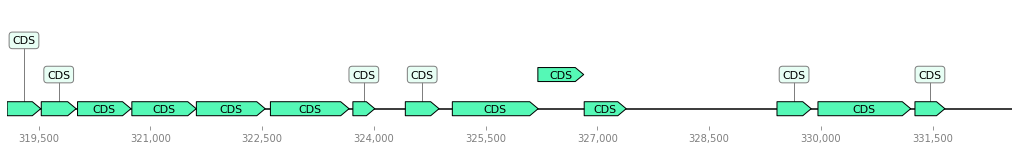

In [2226]:
# Simple plot to visualize the ground truth

features = []
#crop_start = target['start'].iloc[0]-100
#crop_end = target['end'].iloc[len(target)-1]+100
if strand == 1:
        crop_start = kmers_df.Noisy_read_start.loc[read_id]-200
        crop_end = kmers_df.Noisy_read_end.loc[read_id]+200
else:
        crop_end = kmers_df.Noisy_read_start.loc[read_id]+100
        crop_start = kmers_df.Noisy_read_end.loc[read_id]-100
        
for i in range(len(target)):
   
    features.append(GraphicFeature(start=target['start'].iloc[i], end=target['end'].iloc[i], strand=target['strand'].iloc[i], color="#55f8b6",
                       label="CDS"))
    
           
record = GraphicRecord(sequence_length=5000000, features=features)
cropped_record = record.crop((crop_start, crop_end))
ax, _ = cropped_record.plot(figure_width=18)
#ax.figure.savefig(path_to_fig+'35CDS_EcoliUMN.png',bbox_inches='tight')
plt.savefig('A_couples_WG.png', dpi=300)


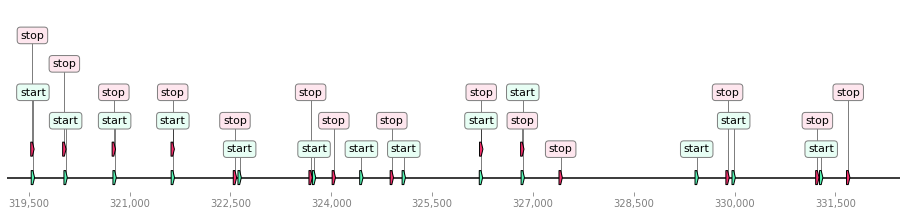

In [2049]:
# Simple plot to visualize the ground truth

features = []
#crop_start = target['start'].iloc[0]-100

#crop_end = target['end'].iloc[len(target)-1]+100

if strand == 1:
        crop_start = kmers_df.Noisy_read_start.loc[read_id]-100
        crop_end = kmers_df.Noisy_read_end.loc[read_id]+100
else:
        crop_end = kmers_df.Noisy_read_start.loc[read_id]+100
        crop_start = kmers_df.Noisy_read_end.loc[read_id]-100

for i in range(len(target)):
    features.append(GraphicFeature(start=target['start'].iloc[i], end=target['start'].iloc[i]+50, strand=target['strand'].iloc[i], color="#55f8b6",
                   label="start"))
    
for i in range(len(target)):
    features.append(GraphicFeature(start=target['end'].iloc[i], end=target['end'].iloc[i]+50, strand=target['strand'].iloc[i], color="#f92f6d",
                   label="stop"))
    
           
record = GraphicRecord(sequence_length=5000000, features=features)
cropped_record = record.crop((crop_start, crop_end))
ax, _ = cropped_record.plot(figure_width=16)
#ax.figure.savefig(path_to_fig+'35CDS_EcoliUMN.png',bbox_inches='tight')
plt.savefig('A_starts_stops_WG.png', dpi=300)

In [2227]:
def get_median_idx(idx_l,zone_size):
    final_idx = []
    buffer= []
    new_zone = True
    for idx in idx_l :
        if new_zone == True:
            buffer.append(idx)
            new_zone = False
        elif idx-buffer[-1] <= zone_size:
            buffer.append(idx)
        else:
            new_zone = True
            final_idx.append(np.round(statistics.median_low(buffer)))
            buffer= []
    return final_idx
            
            
        

In [2228]:
starts_idx_in_read = get_median_idx(starts_idx_in_read,100)
stops_idx_in_read = get_median_idx(stops_idx_in_read,100)


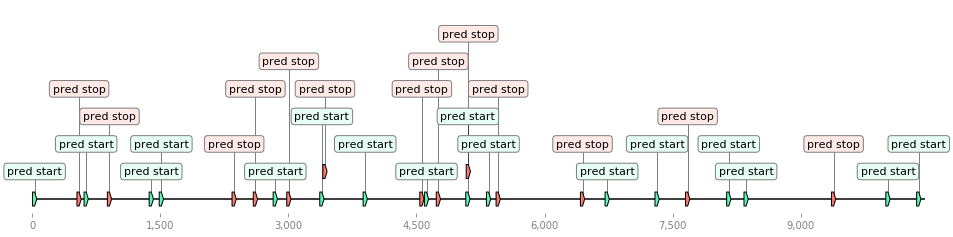

In [2146]:

features = []
crop_start =  starts_idx_in_read[0]-100
if crop_start < 0:
    crop_start = 0
crop_end =  starts_idx_in_read[len(starts_idx_in_read)-1]+ 100

for i in range(len(starts_idx_in_read)):
    features.append(GraphicFeature(start=starts_idx_in_read[i], end=starts_idx_in_read[i]+50, strand=strand, color="#55f8b6",label="pred start"))

        
for i in range(len(stops_idx_in_read)):
    features.append(GraphicFeature(start=stops_idx_in_read[i], end=stops_idx_in_read[i]+50, strand=strand, color="#f97b6d",label="pred stop"))
    
    
record = GraphicRecord(sequence_length=5000000, features=features)
cropped_record = record.crop((crop_start, crop_end))
ax, _ = cropped_record.plot(figure_width=16)

### Give metrics for start and stop predictions

In [2229]:
target_starts_in_read = target['start']
target_stops_in_read = target['end']

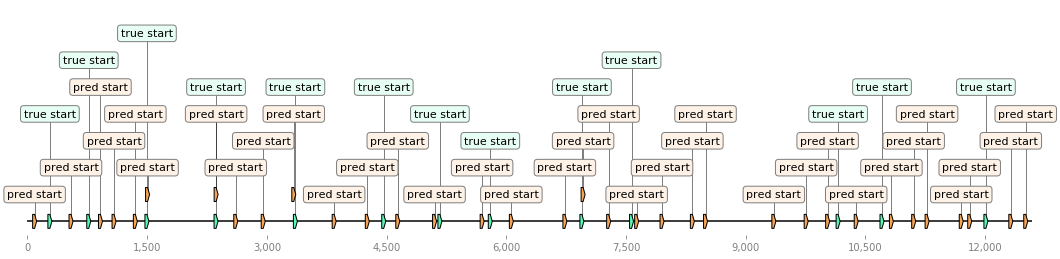

In [2262]:
features = []
crop_start =  starts_idx_in_read[0]-100
if crop_start < 0:
    crop_start = 0
crop_end =  starts_idx_in_read[len(starts_idx_in_read)-1]+100

for i in range(len(target_starts_in_read)):
    if strand == 1:
        features.append(GraphicFeature(start=target_starts_in_read.iloc[i]-kmers_df.Noisy_read_start.loc[read_id], end=target_starts_in_read.iloc[i]-kmers_df.Noisy_read_start.loc[read_id]+50, strand=strand, color="#55f8b6",label="true start"))
    else:
        features.append(GraphicFeature(start=target_starts_in_read.iloc[i]-kmers_df.Noisy_read_end.loc[read_id], end=target_starts_in_read.iloc[i]-kmers_df.Noisy_read_end.loc[read_id]+50, strand=strand, color="#55f8b6",label="true start"))
        #features.append(GraphicFeature(start=kmers_df.Noisy_read_start.loc[read_id]-target_starts_in_read.iloc[i], end=kmers_df.Noisy_read_start.loc[read_id]-target_starts_in_read.iloc[i]+50, strand=strand, color="#55f8b6",label="true start"))

for i in range(len(starts_idx_in_read)):
    features.append(GraphicFeature(start=starts_idx_in_read[i], end=starts_idx_in_read[i]+50, strand=strand, color="#f8a455",label="pred start"))

    
record = GraphicRecord(sequence_length=5000000, features=features)
cropped_record = record.crop((crop_start, crop_end))
ax, _ = cropped_record.plot(figure_width=18)
plt.savefig('A_starts_pred_allkmers.png', dpi=300)


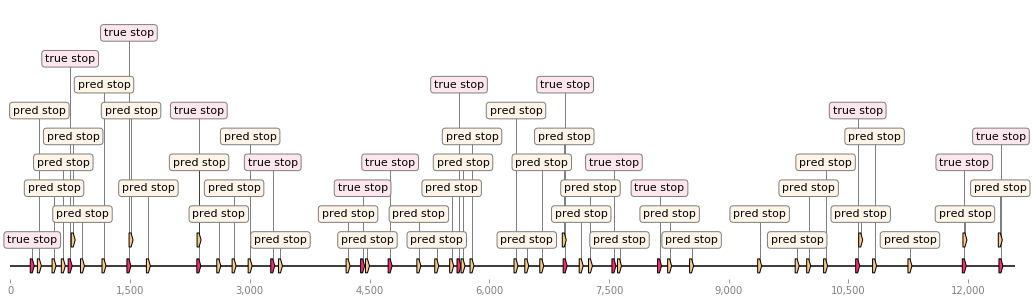

In [2263]:
features = []
crop_start =  starts_idx_in_read[0]-2000
if crop_start < 0:
    crop_start = 0
crop_end =  starts_idx_in_read[len(starts_idx_in_read)-1]+100


for i in range(len(target_stops_in_read)):
    if strand == 1:
        features.append(GraphicFeature(start=target_stops_in_read.iloc[i]-kmers_df.Noisy_read_start.loc[read_id], end=target_stops_in_read.iloc[i]-kmers_df.Noisy_read_start.loc[read_id]+50, strand=strand, color="#f92f6d",label="true stop"))
    else:
        features.append(GraphicFeature(start=target_stops_in_read.iloc[i]-kmers_df.Noisy_read_end.loc[read_id], end=target_stops_in_read.iloc[i]-kmers_df.Noisy_read_end.loc[read_id]+50, strand=strand, color="#f92f6d",label="true stop"))
for i in range(len(stops_idx_in_read)):
    features.append(GraphicFeature(start=stops_idx_in_read[i], end=stops_idx_in_read[i]+50, strand=strand, color="#facb86",label="pred stop"))

    
record = GraphicRecord(sequence_length=5000000, features=features)
cropped_record = record.crop((crop_start, crop_end))
ax, _ = cropped_record.plot(figure_width=18)
plt.savefig('A_stops_pred_allkmers.png', dpi=300)


### Calculate couple scores

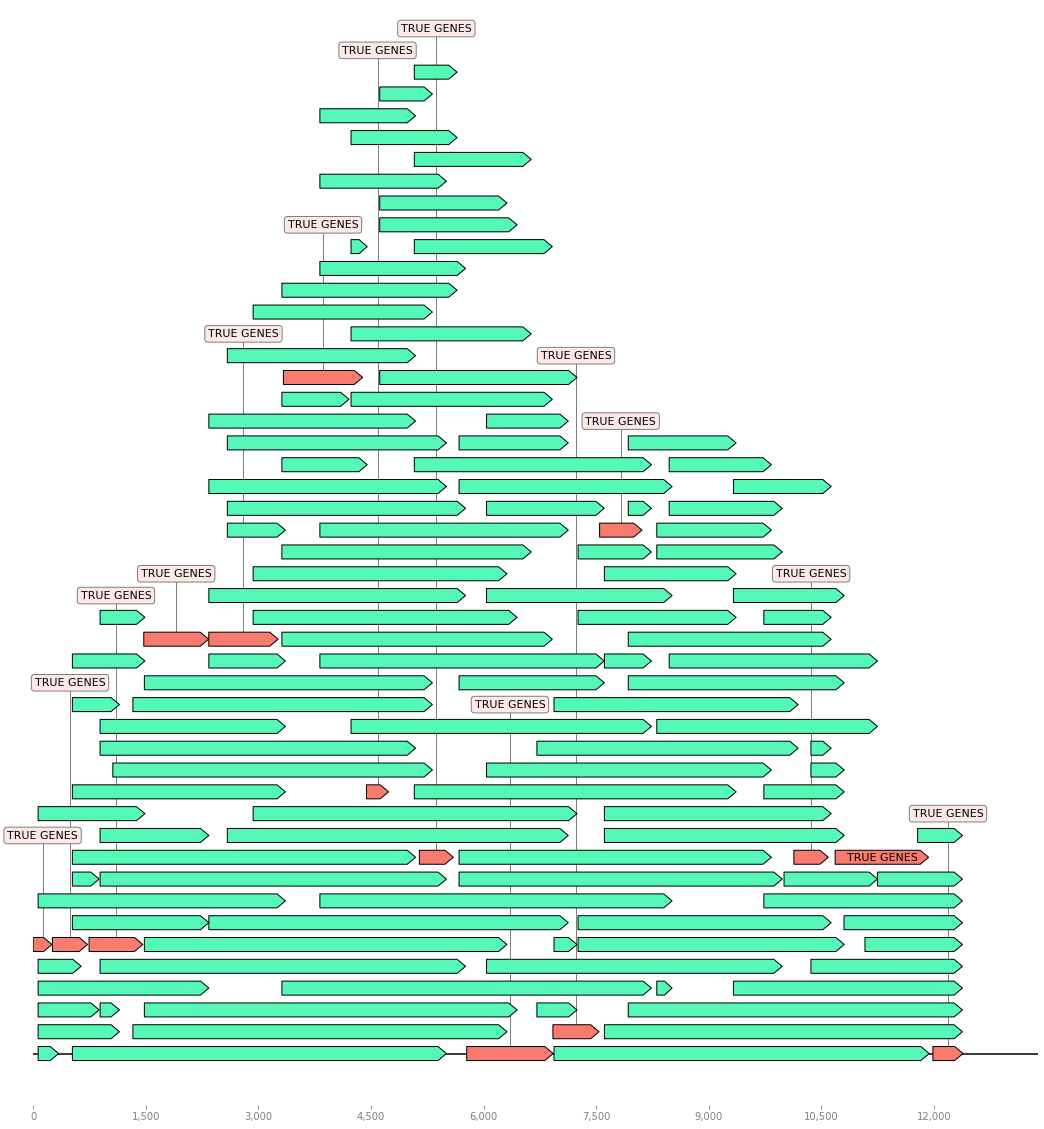

In [2261]:
#gives all the candidate genes on the read
couples = func.find_in_frame_codons(starts_idx_in_read, stops_idx_in_read, strand, 150)
features = []
crop_start =  couples[0][0]-1000
if crop_start < 0:
    crop_start = 0
crop_end =  couples[len(couples)-1][1]+1000
for i, couple in enumerate(couples):
    if strand == 1:
        features.append(GraphicFeature(start=couple[0], end=couple[1], strand=strand, color="#55f8b6"))
    else:
        features.append(GraphicFeature(start=couple[1], end=couple[0], strand=strand, color="#55f8b6"))
    
for i in range(len(target)):
    if strand == 1:
        features.append(GraphicFeature(start=target['start'].iloc[i]-kmers_df.Noisy_read_start.loc[read_id], end=target['end'].iloc[i]-kmers_df.Noisy_read_start.loc[read_id], strand=strand, color="#f97b6d",
                  label="TRUE GENES"))
    else:
        features.append(GraphicFeature(start=target['start'].iloc[i]-kmers_df.Noisy_read_end.loc[read_id], end=target['end'].iloc[i]-kmers_df.Noisy_read_end.loc[read_id], strand=strand, color="#f97b6d",
                  label="TRUE GENES"))

record = GraphicRecord(sequence_length=5000000, features=features)
cropped_record = record.crop((crop_start, crop_end))
ax, _ = cropped_record.plot(figure_width=18)

import matplotlib.pyplot as plt
plt.savefig('A_ORFs_pred_allkmers.png', dpi=300)


In [2233]:
#couples_scores = []
start_sc = []
stop_sc = []
for i, couple in enumerate(couples) : 
    print('Step:',i,'/',len(couples)-1)
    start = couple[0]
    stop = couple[1]
    start_idx = starts_idx_in_read.index(start)
    stop_idx = stops_idx_in_read.index(stop)
    start_score = starts_scores[start_idx] 
    start_sc.append(start_score)
    stop_score = stops_scores[stop_idx]
    stop_sc.append(stop_score)
    #couples_scores.append((start_score,stop_score))
    

Step: 0 / 116
Step: 1 / 116
Step: 2 / 116
Step: 3 / 116
Step: 4 / 116
Step: 5 / 116
Step: 6 / 116
Step: 7 / 116
Step: 8 / 116
Step: 9 / 116
Step: 10 / 116
Step: 11 / 116
Step: 12 / 116
Step: 13 / 116
Step: 14 / 116
Step: 15 / 116
Step: 16 / 116
Step: 17 / 116
Step: 18 / 116
Step: 19 / 116
Step: 20 / 116
Step: 21 / 116
Step: 22 / 116
Step: 23 / 116
Step: 24 / 116
Step: 25 / 116
Step: 26 / 116
Step: 27 / 116
Step: 28 / 116
Step: 29 / 116
Step: 30 / 116
Step: 31 / 116
Step: 32 / 116
Step: 33 / 116
Step: 34 / 116
Step: 35 / 116
Step: 36 / 116
Step: 37 / 116
Step: 38 / 116
Step: 39 / 116
Step: 40 / 116
Step: 41 / 116
Step: 42 / 116
Step: 43 / 116
Step: 44 / 116
Step: 45 / 116
Step: 46 / 116
Step: 47 / 116
Step: 48 / 116
Step: 49 / 116
Step: 50 / 116
Step: 51 / 116
Step: 52 / 116
Step: 53 / 116
Step: 54 / 116
Step: 55 / 116
Step: 56 / 116
Step: 57 / 116
Step: 58 / 116
Step: 59 / 116
Step: 60 / 116
Step: 61 / 116
Step: 62 / 116
Step: 63 / 116
Step: 64 / 116
Step: 65 / 116
Step: 66 / 116
Step:

### Genic Or non genic part

In [2234]:
genic_nn_model = '/Users/lou/Documents/Travail/Projet de master/Scripts/Part6_scoring/models/Genic_WG_LSTMNet_25_numLayer-2_lr-5e-05_batchSize-100_rdSeed-12'
dim_input = 100
dim_recurrent= 25
num_layers = 2
dim_output = 1
learning_rate = 0.00005
epochs = 1
batch_size = 100
seed = 12



In [2235]:
# set model
genic_model = mynn.LSTMNet(dim_input, dim_recurrent, num_layers, dim_output)
print('Model loading :', genic_nn_model ) 
genic_model.load_state_dict(torch.load(genic_nn_model,map_location='cpu'))
# send it to CPU or GPU
genic_model.to(device)
record = 'Get_genic_pred'

#Optimizer
optimizer = torch.optim.Adam(genic_model.parameters(), lr=learning_rate)

Model loading : /Users/lou/Documents/Travail/Projet de master/Scripts/Part6_scoring/models/Genic_WG_LSTMNet_25_numLayer-2_lr-5e-05_batchSize-100_rdSeed-12


In [2236]:
for i,read in enumerate(kmers_df.Noisy_read[read_id:read_id+1]):
    strand = kmers_df.Strand.loc[read_id]
    print('Step:',i)
    embed, kmers = func.Seq_to_vector(read, w2v, 7)
    pred = mynn.predict_network_binary(embed, genic_model, epochs, batch_size, device = device, rdseed = seed)
    #flatten pred
    pred = [item for sublist in pred for item in sublist]
    #compute scores for candidates
    genic_couple_scores = []
    for j,candidate in enumerate(couples):
        print('Step:',j)
        # convert tensor to int
        if strand == 1:
            candidate = int(candidate[0]),int(candidate[1])
        else: 
            candidate = int(candidate[1]),int(candidate[0])
        score = func.compute_genic_score(candidate, pred,strand)
        genic_couple_scores.append(score)
    
        


Step: 0
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99
Step: 100
Step: 101
Step: 102
Step: 103
Step: 104
Step: 105
Step: 106
Step: 107
Step: 108
Step: 109
St

In [2237]:
scores_df = pd.DataFrame(list(zip(couples,start_sc,stop_sc,genic_couple_scores)), columns =['Start_stop','start_sc','stop_sc','genic_sc'])
scores_df['Tot_sc'] = scores_df.start_sc+scores_df.stop_sc+scores_df.genic_sc
scores_df.sample(3) 


,Start_stop,start_sc,stop_sc,genic_sc,Tot_sc
66,"(5077, 9364)",0.750,1.000000,[tensor(0.4367)],[tensor(2.1867)]
70,"(5673, 9834)",0.750,1.000000,[tensor(0.4227)],[tensor(2.1727)]
17,"(891, 3360)",0.875,0.833333,[tensor(0.5743)],[tensor(2.2827)]


In [2256]:
high_genic_couple_scores = [idx for idx, score in enumerate(scores_df.genic_sc) if score >= 0.5 ]
#high_genic_couple_scores = [idx for idx, score in enumerate(scores_df.Tot_sc) if score >= 2.2 ]
high_genic_couple_scores

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 24,
 53,
 72,
 73,
 77,
 79,
 109,
 110,
 112,
 113,
 114,
 115,
 116]

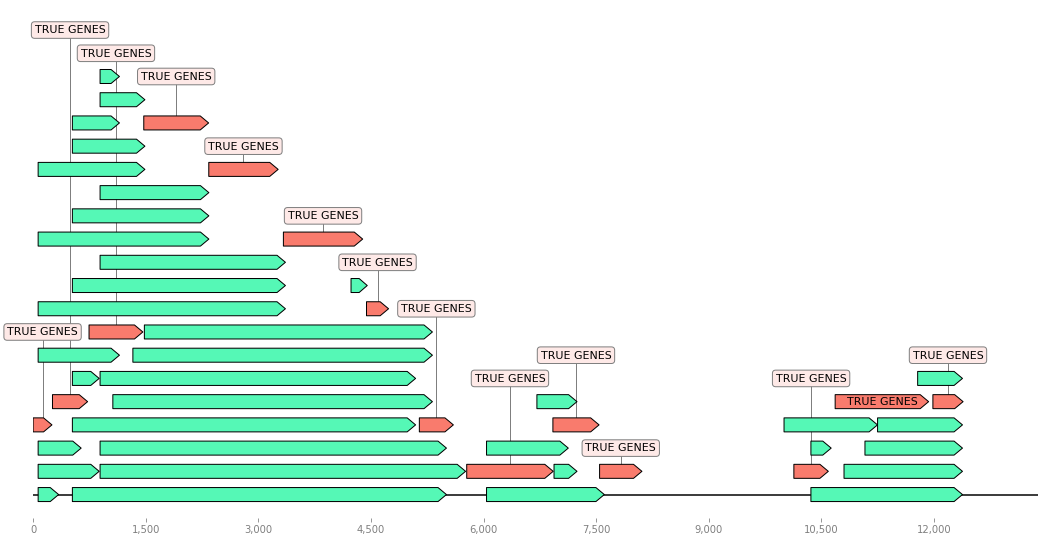

In [2260]:
#gives all the candidate genes on the read
features = []
crop_start = 0  #couples[high_genic_couple_scores[0]][0]-10000
if crop_start < 0:
    crop_start = 0
crop_end =  couples[high_genic_couple_scores[len(high_genic_couple_scores)-1]][1]+1000

for i, idx in enumerate(high_genic_couple_scores):
    couple = couples[idx]
    if strand == 1:
        features.append(GraphicFeature(start=couple[0], end=couple[1], strand=strand, color="#55f8b6"))
    else:
        features.append(GraphicFeature(start=couple[1], end=couple[0], strand=strand, color="#55f8b6"))
    
for i in range(len(target)):
    if strand == 1:
        features.append(GraphicFeature(start=target['start'].iloc[i]-kmers_df.Noisy_read_start.loc[read_id], end=target['end'].iloc[i]-kmers_df.Noisy_read_start.loc[read_id], strand=target['strand'].iloc[i], color="#f97b6d",
                  label="TRUE GENES"))
    else:
        features.append(GraphicFeature(start=target['start'].iloc[i]-kmers_df.Noisy_read_end.loc[read_id], end=target['end'].iloc[i]-kmers_df.Noisy_read_end.loc[read_id], strand=target['strand'].iloc[i], color="#f97b6d",
                  label="TRUE GENES"))


record = GraphicRecord(sequence_length=5000000, features=features)
cropped_record = record.crop((crop_start, crop_end))
ax, _ = cropped_record.plot(figure_width=18)
plt.savefig('A_gene_pred_allkmers_cov50.png', dpi=300)
